In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, wilcoxon, gaussian_kde


In [2]:
#Inflate satmut predictions (logSAD in 4kb window centered on element)

def inflate_snp_predictions(fold_index=[0], fold_suffixes=['']) :

    print("Inflating predictions.")
    
    df_folds = []
    
    scores = None

    #Loop over folds
    for fold_i, [fold_ix, fold_suffix] in enumerate(zip(fold_index, fold_suffixes)) :

        sed = h5py.File('test_satmut/f' + str(fold_ix) + 'c0' + fold_suffix + '/snp_sad_4k/sad.h5', 'r')
        
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        score_mat = sed['SADlog'][()].astype('float32')
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]
        
        #Accumulate variant predictions (cell type- and tissue-specific)
        if fold_i == 0 :
            scores = score_mat.copy()
        else :
            scores += score_mat.copy()
        
        snps = []
        chroms = []
        poses = []
        ref_alleles = []
        alt_alleles = []

        #Loop over rows and append variant metadata
        for si in range(snp_mat.shape[0]) :

            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        #Create dataframe with variants
        df = pd.DataFrame({
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
        })

        df_folds.append(df)

    df = df_folds[0]
    
    #Get element id and measurements
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/satmutmpra/satmutmpra_v1_meas.csv', sep='\t')
    
    df = df.join(vcf_df[['VarID', 'Element', 'Value', 'P-Value']].set_index('VarID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    df = df.rename(columns={
        'Element' : 'element_id',
        'Value' : 'log2fc',
        'P-Value' : 'p_val',
    })
    
    #Divide scores by number of folds (average)
    scores /= float(len(fold_index))
    scores = scores.astype('float16')
    
    return df, scores

df, scores = inflate_snp_predictions([0, 1, 2, 3], ['', '', '', ''])

print("len(df) = " + str(len(df)))
print("scores.shape = " + str(scores.shape))


Inflating predictions.
len(df) = 29444
scores.shape = (29444, 6385)


In [3]:
#Load targets dataframe (stranded)

targets_df = pd.read_csv('targets_human.txt', sep='\t', index_col=0)

#Attach strand
targets_strand = []
for _, target in targets_df.iterrows() :
    if target.strand_pair == target.name:
        targets_strand.append('.')
    else:
        targets_strand.append(target.identifier[-1])
targets_df['strand'] = targets_strand

#Collapse stranded targets
strand_mask = (targets_df.strand != '-')
targets_strand_df = targets_df[strand_mask].copy()

targets_strand_df['row_index'] = np.arange(len(targets_strand_df), dtype='int32')

print("len(targets_strand_df) = " + str(len(targets_strand_df)))


len(targets_strand_df) = 6385


In [4]:
#Remove local (SAD) RNA targets; these will be replaced by logSED predictions for each given gene further down

keep_index = targets_strand_df.loc[~targets_strand_df['description'].str.contains("^RNA:")]['row_index'].values.tolist()

scores = scores[:, keep_index]
targets_strand_df = targets_strand_df.iloc[keep_index].copy()

targets_strand_df['row_index'] = np.arange(len(targets_strand_df), dtype='int32')

print("scores.shape = " + str(scores.shape))
print("len(targets_strand_df) = " + str(len(targets_strand_df)))


scores.shape = (29444, 5430)
len(targets_strand_df) = 5430


In [5]:
#Inflate variant predictions (logSED)

def inflate_snp_predictions_sed(fold_index=[0], fold_suffixes=['']) :

    print("Inflating predictions.")
    
    df_folds = []
    
    scores = None

    #Loop over folds
    for fold_i, [fold_ix, fold_suffix] in enumerate(zip(fold_index, fold_suffixes)) :

        sed = h5py.File('test_satmut/f' + str(fold_ix) + 'c0' + fold_suffix + '/snp_sed/sed.h5', 'r')
        
        gene_id_mat = sed['gene'][()]
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        score_mat = score_mat = sed['logSED'][()].astype('float32')
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]
        
        #Accumulate variant predictions
        if fold_i == 0 :
            scores = score_mat.copy()
        else :
            scores += score_mat.copy()
        
        gene_ids = []
        snps = []
        chroms = []
        poses = []
        ref_alleles = []
        alt_alleles = []

        #Loop over variants and append metadata
        for i, si in enumerate(sed['si'][()].tolist()) :

            gene_ids.append(gene_id_mat[i].decode())
            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        #Create dataframe
        df = pd.DataFrame({
            'gene_id' : gene_ids,
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
        })

        df_folds.append(df)

    df = df_folds[0]
    
    #Get element id and measurements
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/satmutmpra/satmutmpra_v1_meas.csv', sep='\t')
    
    df = df.join(vcf_df[['VarID', 'Element', 'Value', 'P-Value']].set_index('VarID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    df = df.rename(columns={
        'Element' : 'element_id',
        'Value' : 'log2fc',
        'P-Value' : 'p_val',
    })
    
    df['gene_base'] = df['gene_id'].apply(lambda x: x.split(".")[0] if "." in x else x)
    df['row_index'] = np.arange(len(df), dtype='int32')
    
    #Divide variant predictions by number of folds (average)
    scores /= float(len(fold_index))
    scores = scores.astype('float16')
    
    return df, scores

df_sed, scores_sed = inflate_snp_predictions_sed([0, 1, 2, 3], ['', '', '', ''])

print("len(df_sed) = " + str(len(df_sed)))
print("scores_sed.shape = " + str(scores_sed.shape))


Inflating predictions.
len(df_sed) = 415997
scores_sed.shape = (415997, 955)


In [6]:
#Match SED scores by gene

element_to_gene_id_dict = {
    "F9" : "ENSG00000101981",
    "LDLR" : "ENSG00000130164",
    "SORT1" : "ENSG00000134243",
    "GP1BA" : "ENSG00000203618",
    "HBB" : "ENSG00000244734",
    "HBG1" : "ENSG00000213934",
    "PKLR" : "ENSG00000143627",
    "HNF4A" : "ENSG00000101076",
    "MSMB" : "ENSG00000263639",
    "TERT" : "ENSG00000164362",
    "MYCrs6983267" : "ENSG00000136997",
    "ZFAND3" : "ENSG00000156639",
    "IRF6" : "ENSG00000117595",
    "IRF4" : "ENSG00000137265",
}

gene_ids_matched = []

#Loop over variants
for _, row in df_sed.iterrows() :
    if row['element_id'] in element_to_gene_id_dict :
        gene_ids_matched.append(element_to_gene_id_dict[row['element_id']])
    else :
        gene_ids_matched.append('NO_GENE')

df_sed['gene_base_matched'] = gene_ids_matched

#Select predictions only for the target gene of each element
df_sed = df_sed.query("gene_base == gene_base_matched").copy().reset_index(drop=True)

scores_sed = scores_sed[df_sed['row_index'].values.tolist(), :]

print("len(df_sed) = " + str(len(df_sed)))
print("scores_sed.shape = " + str(scores_sed.shape))


len(df_sed) = 15881
scores_sed.shape = (15881, 955)


In [7]:
#Load targets dataframe (stranded)

targets_df_sed = pd.read_csv('targets_human_rna.txt', sep='\t', index_col=0)

#Attach strand
targets_strand = []
for _, target in targets_df_sed.iterrows() :
    if target.strand_pair == target.name:
        targets_strand.append('.')
    else:
        targets_strand.append(target.identifier[-1])
targets_df_sed['strand'] = targets_strand

#Collapse stranded targets
strand_mask = (targets_df_sed.strand != '-')
targets_strand_df_sed = targets_df_sed[strand_mask].copy()

targets_strand_df_sed['row_index'] = np.arange(len(targets_strand_df_sed), dtype='int32')

print("len(targets_strand_df_sed) = " + str(len(targets_strand_df_sed)))


len(targets_strand_df_sed) = 955


In [8]:
#Merge SAD and SED scores (0s for missing values)

#Get dictionary mapping variant IDs to SED dataframe rows
sed_snp_to_row_dict = {
    row['snp'] : row_ix for row_ix, [_, row] in enumerate(df_sed.iterrows())
}

scores_sed = np.concatenate([
    scores_sed,
    np.zeros((1, scores_sed.shape[1])),
], axis=0)

row_index_sed = []
#Loop over SAD dataframe rows
for _, row in df.iterrows() :
    if row['snp'] in sed_snp_to_row_dict :
        row_index_sed.append(sed_snp_to_row_dict[row['snp']])
    else :
        row_index_sed.append(scores_sed.shape[0] - 1)

#Get SED scores according to SAD dataframe sort order
scores_sed_new = scores_sed[row_index_sed, :]

#Concatenate scores
scores = np.concatenate([
    scores,
    scores_sed_new
], axis=1)

#Concatenate targets
targets_strand_df = pd.concat([
    targets_strand_df,
    targets_strand_df_sed,
])

targets_strand_df['row_index'] = np.arange(len(targets_strand_df), dtype='int32')

print("scores.shape = " + str(scores.shape))
print("len(targets_strand_df) = " + str(len(targets_strand_df)))


scores.shape = (29444, 6385)
len(targets_strand_df) = 6385


In [9]:
#Match enhancers to target cell types (DNase, histone marks and RNA)

dnase_dict = {
    #HepG2
    "F9" : "DNASE:K562$", #promoter #Original -> "DNASE:HepG2$"
    "LDLR" : "DNASE:adrenal gland.*", #promoter #Original -> "DNASE:HepG2$"
    "SORT1" : "DNASE:HepG2$", #enhancer
    
    #K562
    "GP1BA" : "DNASE:K562$", #promoter
    "HBB" : "DNASE:K562$", #promoter
    "HBG1" : "DNASE:K562$", #promoter
    "PKLR" : "DNASE:K562$", #promoter
    
    #DNASE:HEK293T
    "HNF4A" : "DNASE:HEK293T$", #promoter
    "MSMB" : "DNASE:HEK293T$", #promoter
    "TERT" : "DNASE:HEK293T$", #promoter
    "MYCrs6983267" : "DNASE:HEK293T$", #enhancer
    
    #MIN6 (pancreas)
    "ZFAND3" : "DNASE:.*pancreas.*", #enhancer
    
    #HaCaT (keratinocyte)
    "IRF6" : "DNASE:.*keratinocyte.*", #enhancer
    
    #SK-MEL-28 (SK-MEL)
    "IRF4" : "DNASE:.*SK-MEL.*|DNASE:melanocyte of skin.*|DNASE:foreskin melanocyte.*", #enhancer
}

h3k_dict = {
    #HepG2
    "F9" : "CHIP:H3K4me3:K562$", #promoter #Original -> "CHIP:H3K4me3:HepG2$"
    "LDLR" : "CHIP:H3K4me3:adrenal gland.*", #promoter #Original -> "CHIP:H3K4me3:HepG2$"
    "SORT1" : "CHIP:H3K9ac:HepG2$|CHIP:H3K4me1:HepG2$", #enhancer
    
    #K562
    "GP1BA" : "CHIP:H3K4me3:K562$", #promoter
    "HBB" : "CHIP:H3K4me3:K562$", #promoter
    "HBG1" : "CHIP:H3K4me3:K562$", #promoter
    "PKLR" : "CHIP:H3K4me3:K562$", #promoter
    
    #HEK293T
    "HNF4A" : "CHIP:H3K4me3:HEK293$", #promoter
    "MSMB" : "CHIP:H3K4me3:HEK293$", #promoter
    "TERT" : "CHIP:H3K4me3:HEK293$", #promoter
    "MYCrs6983267" : "CHIP:H3K4me1:HEK293$", #enhancer
    
    #MIN6 (pancreas)
    "ZFAND3" : "CHIP:H3K4me1.*pancreas.*|CHIP:H3K27ac.*pancreas.*", #enhancer
    
    #HaCaT (keratinocyte)
    "IRF6" : "CHIP:H3K4me1.*keratinocyte.*|CHIP:H3K27ac.*keratinocyte.*", #enhancer

    #SK-MEL-28 (SK-MEL)
    "IRF4" : "CHIP:H3K4me1.*SK-MEL.*|CHIP:H3K4me1.*melanocyte of skin.*|CHIP:H3K4me1.*foreskin melanocyte.*", #enhancer
}

rna_dict = {
    #HepG2
    "F9" : "RNA:K562$|RNA:K562 cytosolic fraction$|RNA:K562 treated with 1% DMSO.*|RNA:K562 membrane fraction$", #promoter #Original -> "RNA:HepG2$"
    "LDLR" : "RNA:adrenal gland.*|RNA:adrenal_gland.*", #promoter #Original -> "RNA:HepG2$"
    "SORT1" : "RNA:HepG2$", #enhancer
    
    #K562
    "GP1BA" : "RNA:K562$|RNA:K562 cytosolic fraction$|RNA:K562 treated with 1% DMSO.*|RNA:K562 membrane fraction$", #promoter
    "HBB" : "RNA:K562$|RNA:K562 cytosolic fraction$|RNA:K562 treated with 1% DMSO.*|RNA:K562 membrane fraction$", #promoter
    "HBG1" : "RNA:K562$|RNA:K562 cytosolic fraction$|RNA:K562 treated with 1% DMSO.*|RNA:K562 membrane fraction$", #promoter
    "PKLR" : "RNA:K562$|RNA:K562 cytosolic fraction$|RNA:K562 treated with 1% DMSO.*|RNA:K562 membrane fraction$", #promoter
    
    #HEK293T
    "HNF4A" : "RNA:adrenal gland.*|RNA:adrenal_gland.*", #promoter #Original -> "RNA:HEK293T$"
    "MSMB" : "RNA:adrenal gland.*|RNA:adrenal_gland.*", #promoter #Original -> "RNA:HEK293T$"
    "TERT" : "RNA:adrenal gland.*|RNA:adrenal_gland.*", #promoter #Original -> "RNA:HEK293T$"
    "MYCrs6983267" : "RNA:adrenal gland.*|RNA:adrenal_gland.*", #enhancer #Original -> "RNA:HEK293T$"
    
    #MIN6 (pancreas)
    "ZFAND3" : "RNA:.*pancreas.*", #enhancer
    
    #HaCaT (keratinocyte)
    "IRF6" : "RNA:.*keratinocyte.*", #enhancer
    
    #SK-MEL-28 (SK-MEL)
    "IRF4" : "RNA:.*SK-MEL.*|RNA:melanocyte of skin.*|RNA:foreskin melanocyte.*", #enhancer
}

dnase_and_h3k_dict = {
    element : dnase_dict[element] + "|" + h3k_dict[element]
    for element in dnase_dict
}

dnase_and_h3k_and_rna_dict = {
    element : dnase_dict[element] + "|" + h3k_dict[element] + "|" + rna_dict[element]
    for element in dnase_dict
}


In [10]:
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function for plotting letters along axis
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

#Helper function for plotting sequence logos based on contribution scores
def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

#Helper function to get nucleotide identity (index)
def _letter_to_nt_ix(letter) :
    if letter == 'A' :
        return 0
    elif letter == 'C' :
        return 1
    elif letter == 'G' :
        return 2
    elif letter == 'T' :
        return 3

    return -1

#Helper function for plotting and recording prediction performance per element
def _plot_and_record_perf(target_mode, target_dict, elements, max_p_val=1., n_sample_kde=500, save_figs=[], fig_name='default', plot_isms=[]) :
    
    pearson_rs = []
    spearman_rs = []

    #Loop over elements
    for element_i, element in enumerate(elements) :

        print("element = '" + element + "'")

        #Get variant rows within element
        keep_index = np.nonzero(((df['element_id'] == element) & (df['p_val'] <= max_p_val)).values)[0]

        #Match output track indices depending on the element and type of prediction
        if target_mode == 'specific' :
            if element not in target_dict :
                pearson_rs.append(0.)
                spearman_rs.append(0.)
                continue
            
            target_index = targets_strand_df.loc[targets_strand_df['description'].str.contains(target_dict[element])]['row_index'].tolist()
        elif target_mode == 'dnase' :
            target_index = targets_strand_df.loc[targets_strand_df['description'].str.contains("^DNASE:")]['row_index'].tolist()
        elif target_mode == 'dnase_and_h3k' :
            target_index = targets_strand_df.loc[targets_strand_df['description'].str.contains("^DNASE:|^CHIP:H3K4me3:|^CHIP:H3K4me1:|^CHIP:H3K9ac:|^CHIP:H3K27ac:")]['row_index'].tolist()
        elif target_mode == 'rna' :
            target_index = targets_strand_df.loc[targets_strand_df['description'].str.contains("^RNA:") & targets_strand_df['identifier'].str.contains("^ENC")]['row_index'].tolist()
        elif target_mode == 'dnase_and_h3k_and_rna' :
            target_index = targets_strand_df.loc[targets_strand_df['description'].str.contains("^DNASE:|^CHIP:H3K4me3:|^CHIP:H3K4me1:|^CHIP:H3K9ac:|^CHIP:H3K27ac:|^RNA:")]['row_index'].tolist()

        if len(target_index) == 0 :
            pearson_rs.append(0.)
            spearman_rs.append(0.)
            continue
        
        s = scores[keep_index, :][:, target_index]
        
        valid_index = np.nonzero(np.abs(np.sum(s, axis=0)) != 0.)[0]
        s = s[:, valid_index]
        
        if s.shape[1] == 0 :
            pearson_rs.append(0.)
            spearman_rs.append(0.)
            continue

        y_hat = np.mean(s, axis=-1)
        y = df.iloc[keep_index]['log2fc'].values

        print(" - n datapoints = " + str(y.shape[0]))
        print(" - n targets    = " + str(s.shape[1]))

        spearman_r = spearmanr(y_hat, y)[0]
        pearson_r = pearsonr(y_hat, y)[0]

        spearman_rs.append(spearman_r)
        pearson_rs.append(pearson_r)

        #Fit gaussian kde
        sample_index = np.arange(y.shape[0], dtype='int32')
        np.random.shuffle(sample_index)
        sample_index = sample_index[:n_sample_kde]

        vals = np.concatenate([
            y_hat[None, :],
            y[None, :],
        ], axis=0)

        gkernel = gaussian_kde(vals[:, sample_index])(vals)

        f = None
        if element in save_figs :
            f = plt.figure(figsize=(3, 3), dpi=1200)
        else :
            f = plt.figure(figsize=(3, 3))

        if element in save_figs :
            plt.scatter(y_hat, y, c=gkernel, cmap='viridis', s=4, alpha=0.9, rasterized=True)
        else :
            plt.scatter(y_hat, y, c=gkernel, cmap='viridis', s=4, alpha=0.9)

        plt.axvline(x=0., linewidth=1, linestyle='--', color='black')
        plt.axhline(y=0., linewidth=1, linestyle='--', color='black')

        plt.xlabel('Predicted SAD (log2)', fontsize=8)
        plt.ylabel('Measured FC (log2)', fontsize=8)

        plt.title(element + '; n = ' + str(y.shape[0]) + ' (window = 4kb)\nSpearman = ' + str(round(spearman_r, 3)) + ', Pearson = ' + str(round(pearson_r, 3)), fontsize=8)

        plt.tight_layout()
        
        if element in save_figs :
            plt.savefig(fig_name + '_scatter_' + element + '.pdf')

        plt.show()
        
        #Optionally plot ISM sequence logos
        if element in plot_isms :
            
            #Get range of sequence positions relative to start
            start_pos = np.min(df.iloc[keep_index]['pos'].values)
            end_pos = np.max(df.iloc[keep_index]['pos'].values)

            snps = df.iloc[keep_index]['snp'].values.tolist()

            #Matrices to hold isms
            onehot = np.zeros((end_pos - start_pos + 1, 4))
            ism_hat = np.zeros((end_pos - start_pos + 1, 4))
            ism = np.zeros((end_pos - start_pos + 1, 4))

            #Inflate ism matrix
            for snp_i, snp in enumerate(snps) :
                _, pos, ref, alt = snp.split("_")

                #Accumulate effect sizes per position
                onehot[int(pos) - start_pos, _letter_to_nt_ix(ref)] = 1.
                ism_hat[int(pos) - start_pos, _letter_to_nt_ix(alt)] = y_hat[snp_i]
                ism[int(pos) - start_pos, _letter_to_nt_ix(alt)] = y[snp_i]

            #Compuate average scores per position and broadcast back to reference one-hot
            ism_hat = np.mean(ism_hat, axis=-1)[:, None] * onehot
            ism = np.mean(ism, axis=-1)[:, None] * onehot
            
            print("np.min(ism_hat) = " + str(round(np.min(-ism_hat), 3)))
            print("np.max(ism_hat) = " + str(round(np.max(-ism_hat), 3)))
            
            print("np.min(ism) = " + str(round(np.min(-ism), 3)))
            print("np.max(ism) = " + str(round(np.max(-ism), 3)))

            #Normalize to max score 1
            ism_hat /= np.max(np.abs(ism_hat))
            ism /= np.max(np.abs(ism))

            plot_seq_scores(-ism_hat, figsize=(8, 1), plot_y_ticks=False, y_min=None, y_max=None, save_figs=True if element in save_figs else False, fig_name=fig_name + '_ism_pred_' + element)
            plot_seq_scores(-ism, figsize=(8, 1), plot_y_ticks=False, y_min=None, y_max=None, save_figs=True if element in save_figs else False, fig_name=fig_name + '_ism_true_' + element)

    pearson_rs = np.array(pearson_rs)
    spearman_rs = np.array(spearman_rs)
    
    return pearson_rs, spearman_rs


In [11]:
#Define list of elements

elements = [
    "F9",
    "LDLR",
    "SORT1",
    "GP1BA",
    "HBB",
    "HBG1",
    "PKLR",
    "HNF4A",
    "MSMB",
    "TERT",
    "MYCrs6983267",
    "ZFAND3",
    "IRF6",
    "IRF4",
]

element_types = [
    "Promoter",
    "Promoter",
    "Enhancer",
    "Promoter",
    "Promoter",
    "Promoter",
    "Promoter",
    "Promoter",
    "Promoter",
    "Promoter",
    "Enhancer",
    "Enhancer",
    "Enhancer",
    "Enhancer",
]


--- Cell type-agnostic DNase ---
element = 'F9'
 - n datapoints = 904
 - n targets    = 674


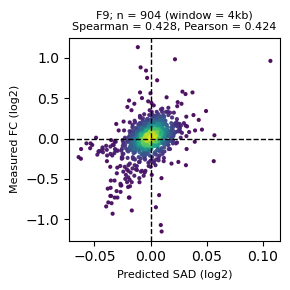

element = 'LDLR'
 - n datapoints = 954
 - n targets    = 674


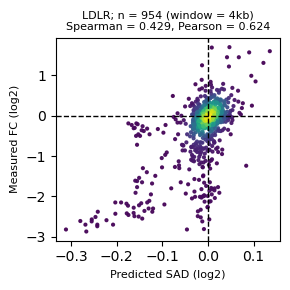

element = 'SORT1'
 - n datapoints = 1800
 - n targets    = 674


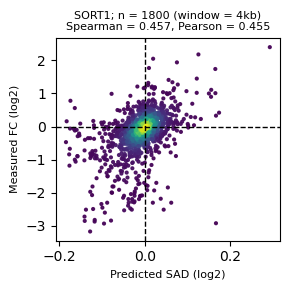

element = 'GP1BA'
 - n datapoints = 1154
 - n targets    = 674


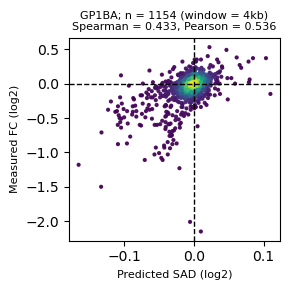

element = 'HBB'
 - n datapoints = 561
 - n targets    = 674


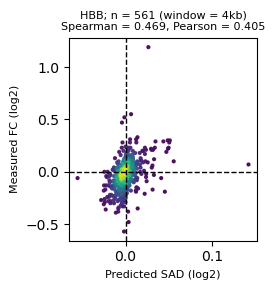

element = 'HBG1'
 - n datapoints = 822
 - n targets    = 674


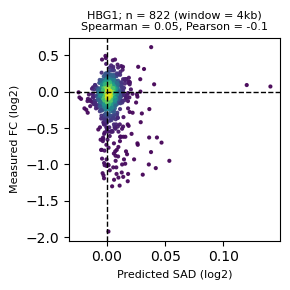

element = 'PKLR'
 - n datapoints = 1407
 - n targets    = 674


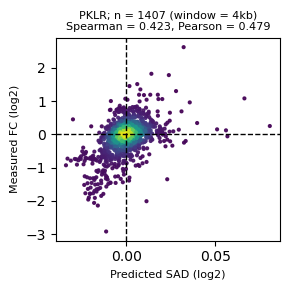

element = 'HNF4A'
 - n datapoints = 855
 - n targets    = 674


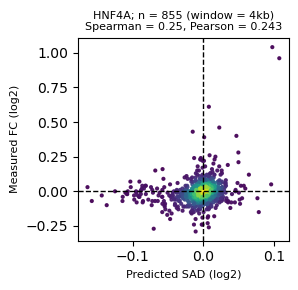

element = 'MSMB'
 - n datapoints = 1773
 - n targets    = 674


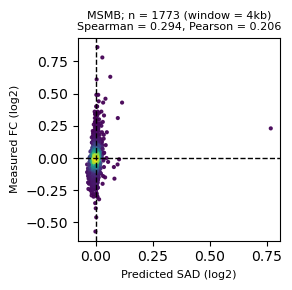

element = 'TERT'
 - n datapoints = 777
 - n targets    = 674


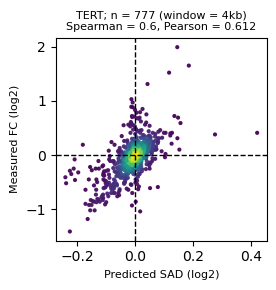

element = 'MYCrs6983267'
 - n datapoints = 1792
 - n targets    = 674


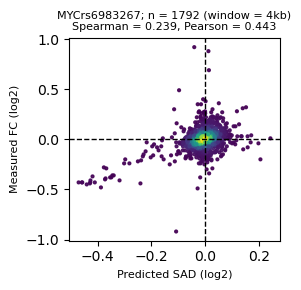

element = 'ZFAND3'
 - n datapoints = 1736
 - n targets    = 674


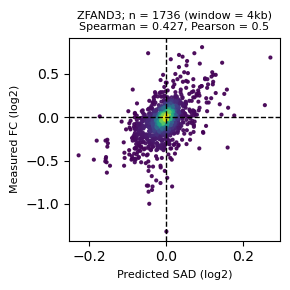

element = 'IRF6'
 - n datapoints = 1785
 - n targets    = 674


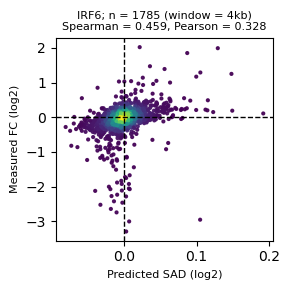

element = 'IRF4'
 - n datapoints = 1353
 - n targets    = 674


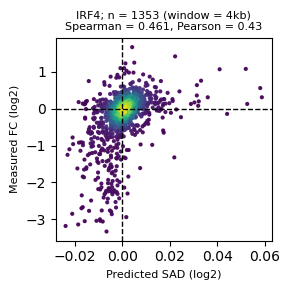

In [12]:
#Plot and record performances (pearson/spearman correlations)

print("--- Cell type-agnostic DNase ---")

target_mode = 'dnase'
target_dict = dnase_dict

pearson_rs_dnase_agnostic, spearman_rs_dnase_agnostic = _plot_and_record_perf(target_mode, target_dict, elements, max_p_val=1., n_sample_kde=500)


--- Cell type-specific DNase ---
element = 'F9'
 - n datapoints = 904
 - n targets    = 4


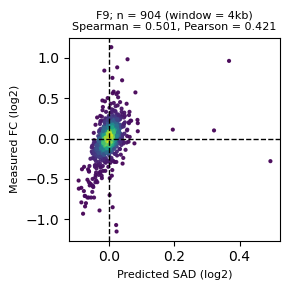

element = 'LDLR'
 - n datapoints = 954
 - n targets    = 11


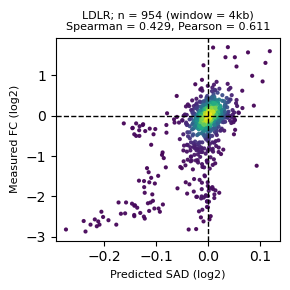

element = 'SORT1'
 - n datapoints = 1800
 - n targets    = 3


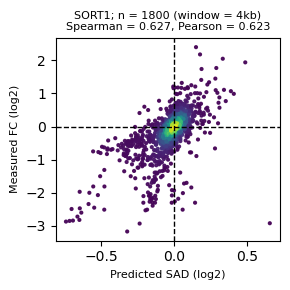

element = 'GP1BA'
 - n datapoints = 1154
 - n targets    = 4


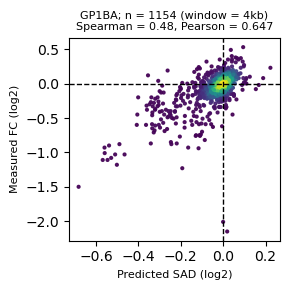

element = 'HBB'
 - n datapoints = 561
 - n targets    = 4


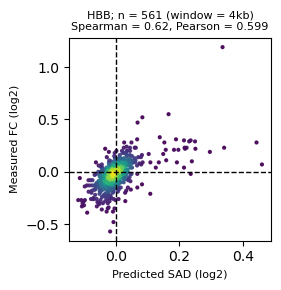

np.min(ism_hat) = -0.27
np.max(ism_hat) = 0.067
np.min(ism) = -0.292
np.max(ism) = 0.238


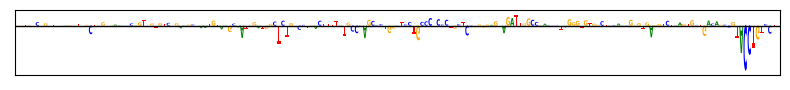

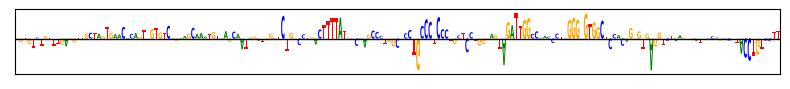

element = 'HBG1'
 - n datapoints = 822
 - n targets    = 4


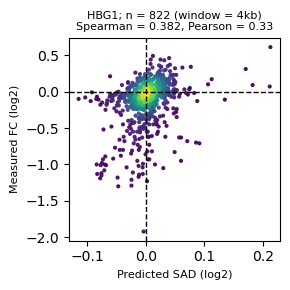

np.min(ism_hat) = -0.071
np.max(ism_hat) = 0.056
np.min(ism) = -0.238
np.max(ism) = 0.842


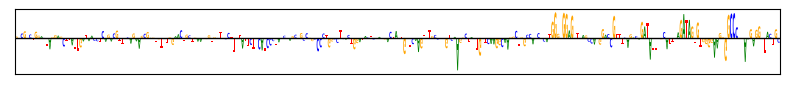

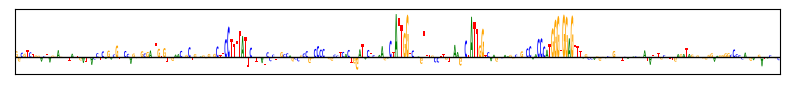

element = 'PKLR'
 - n datapoints = 1407
 - n targets    = 4


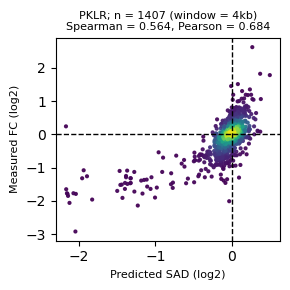

element = 'HNF4A'
 - n datapoints = 855
 - n targets    = 1


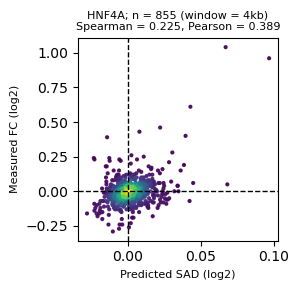

element = 'MSMB'
 - n datapoints = 1773
 - n targets    = 1


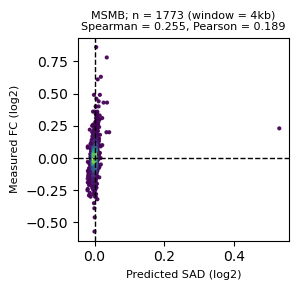

element = 'TERT'
 - n datapoints = 777
 - n targets    = 1


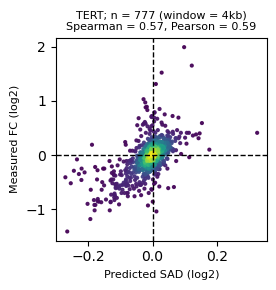

element = 'MYCrs6983267'
 - n datapoints = 1792
 - n targets    = 1


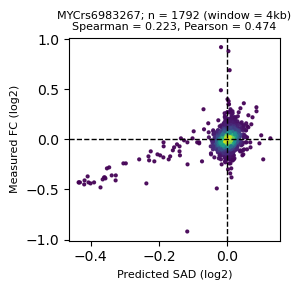

element = 'ZFAND3'
 - n datapoints = 1736
 - n targets    = 6


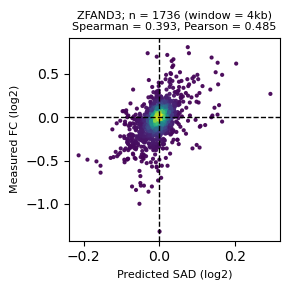

element = 'IRF6'
 - n datapoints = 1785
 - n targets    = 4


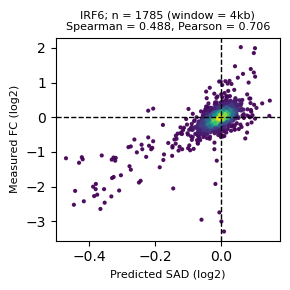

element = 'IRF4'
 - n datapoints = 1353
 - n targets    = 4


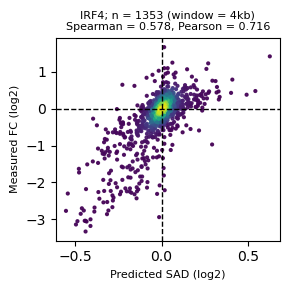

In [13]:
#Plot and record performances (pearson/spearman correlations)

print("--- Cell type-specific DNase ---")

target_mode = 'specific'
target_dict = dnase_dict

pearson_rs_dnase, spearman_rs_dnase = _plot_and_record_perf(target_mode, target_dict, elements, max_p_val=1., n_sample_kde=500, plot_isms=['HBB', 'HBG1'])


--- Cell type-agnostic DNase + H3K ---
element = 'F9'
 - n datapoints = 904
 - n targets    = 1599


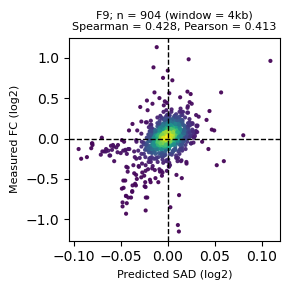

element = 'LDLR'
 - n datapoints = 954
 - n targets    = 1599


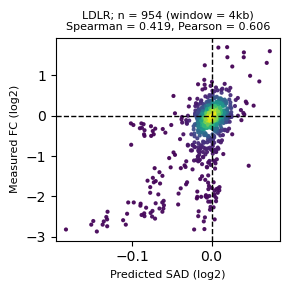

element = 'SORT1'
 - n datapoints = 1800
 - n targets    = 1599


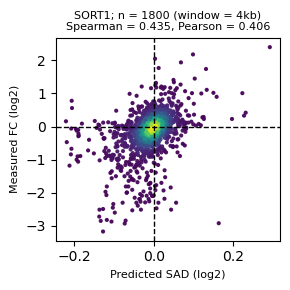

element = 'GP1BA'
 - n datapoints = 1154
 - n targets    = 1599


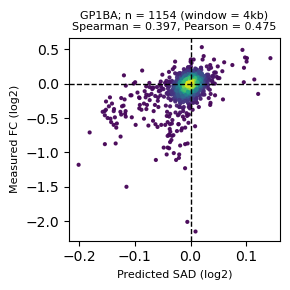

element = 'HBB'
 - n datapoints = 561
 - n targets    = 1599


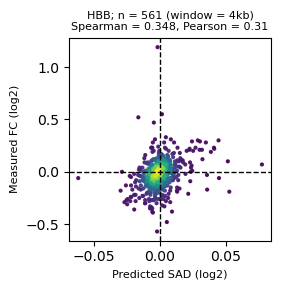

element = 'HBG1'
 - n datapoints = 822
 - n targets    = 1599


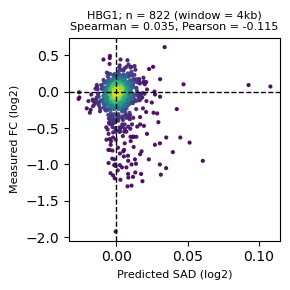

element = 'PKLR'
 - n datapoints = 1407
 - n targets    = 1599


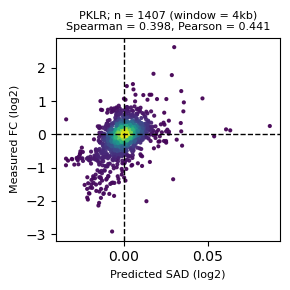

element = 'HNF4A'
 - n datapoints = 855
 - n targets    = 1599


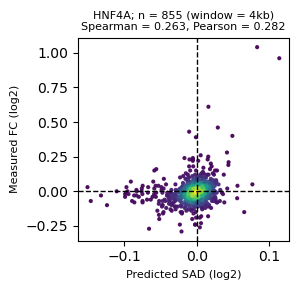

element = 'MSMB'
 - n datapoints = 1773
 - n targets    = 1599


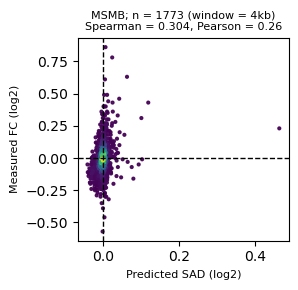

element = 'TERT'
 - n datapoints = 777
 - n targets    = 1599


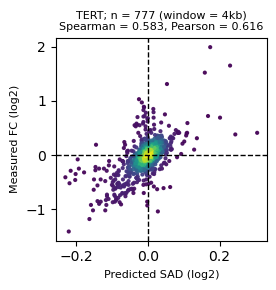

element = 'MYCrs6983267'
 - n datapoints = 1792
 - n targets    = 1599


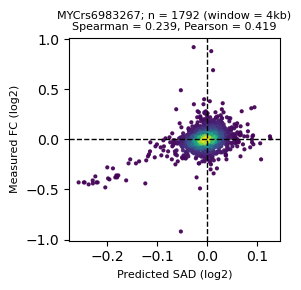

element = 'ZFAND3'
 - n datapoints = 1736
 - n targets    = 1599


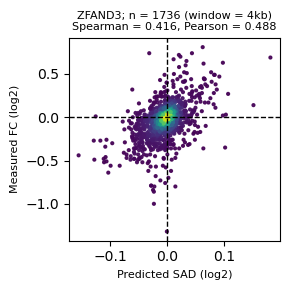

element = 'IRF6'
 - n datapoints = 1785
 - n targets    = 1599


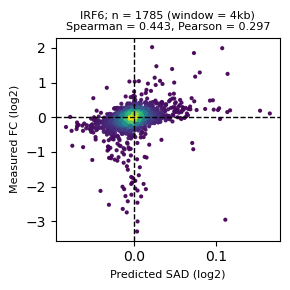

element = 'IRF4'
 - n datapoints = 1353
 - n targets    = 1599


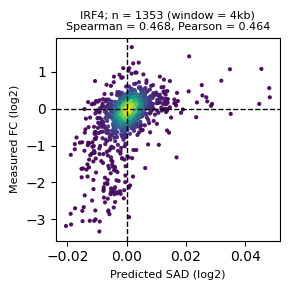

In [14]:
#Plot and record performances (pearson/spearman correlations)

print("--- Cell type-agnostic DNase + H3K ---")

target_mode = 'dnase_and_h3k'
target_dict = dnase_and_h3k_dict

pearson_rs_dnase_and_h3k_agnostic, spearman_rs_dnase_and_h3k_agnostic = _plot_and_record_perf(target_mode, target_dict, elements, max_p_val=1., n_sample_kde=500)


--- Cell type-specific DNase + H3K ---
element = 'F9'
 - n datapoints = 904
 - n targets    = 8


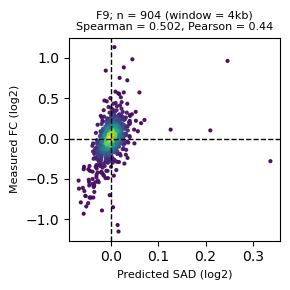

element = 'LDLR'
 - n datapoints = 954
 - n targets    = 17


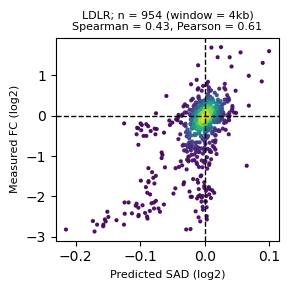

element = 'SORT1'
 - n datapoints = 1800
 - n targets    = 5


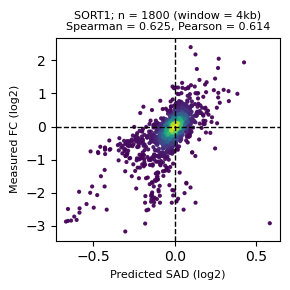

element = 'GP1BA'
 - n datapoints = 1154
 - n targets    = 8


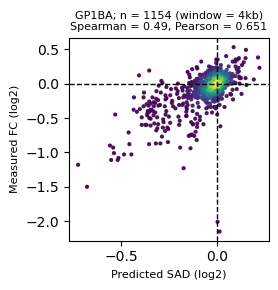

element = 'HBB'
 - n datapoints = 561
 - n targets    = 8


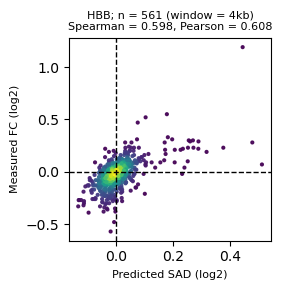

element = 'HBG1'
 - n datapoints = 822
 - n targets    = 8


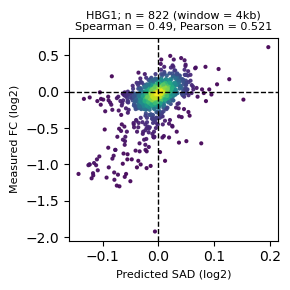

element = 'PKLR'
 - n datapoints = 1407
 - n targets    = 8


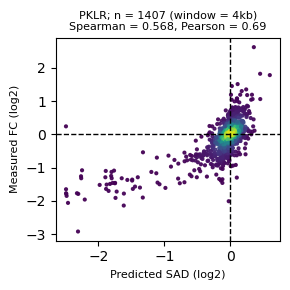

element = 'HNF4A'
 - n datapoints = 855
 - n targets    = 2


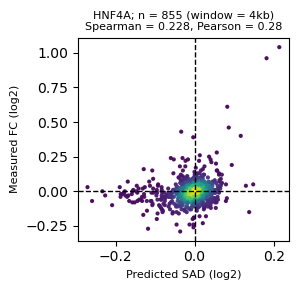

element = 'MSMB'
 - n datapoints = 1773
 - n targets    = 2


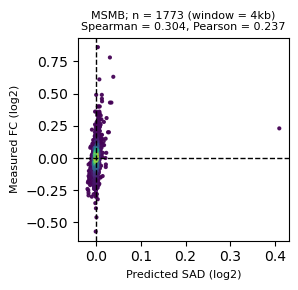

element = 'TERT'
 - n datapoints = 777
 - n targets    = 2


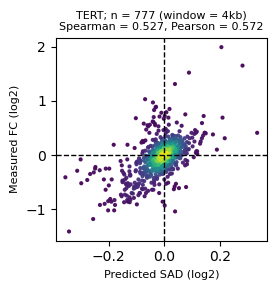

element = 'MYCrs6983267'
 - n datapoints = 1792
 - n targets    = 2


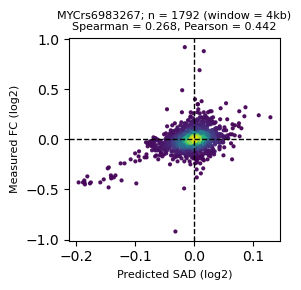

element = 'ZFAND3'
 - n datapoints = 1736
 - n targets    = 20


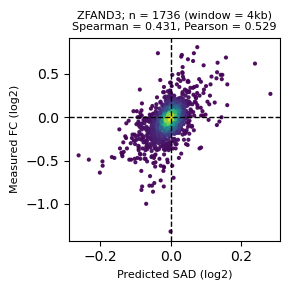

element = 'IRF6'
 - n datapoints = 1785
 - n targets    = 9


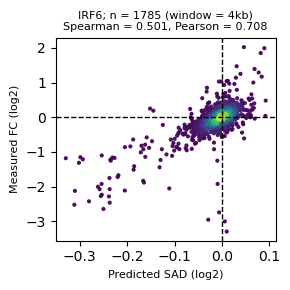

element = 'IRF4'
 - n datapoints = 1353
 - n targets    = 7


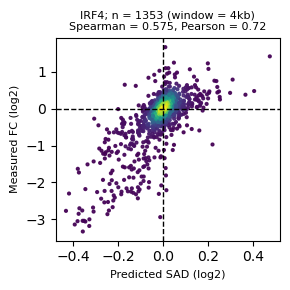

In [15]:
#Plot and record performances (pearson/spearman correlations)

print("--- Cell type-specific DNase + H3K ---")

target_mode = 'specific'
target_dict = dnase_and_h3k_dict

pearson_rs_dnase_and_h3k, spearman_rs_dnase_and_h3k = _plot_and_record_perf(target_mode, target_dict, elements, max_p_val=1., n_sample_kde=500)


--- Cell type-agnostic RNA ---
element = 'F9'
 - n datapoints = 904
 - n targets    = 866


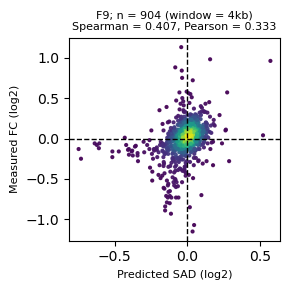

element = 'LDLR'
 - n datapoints = 954
 - n targets    = 866


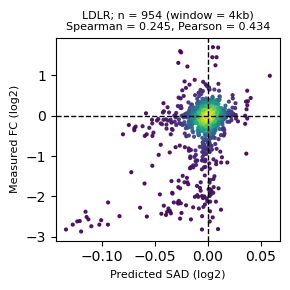

element = 'SORT1'
 - n datapoints = 1800
 - n targets    = 866


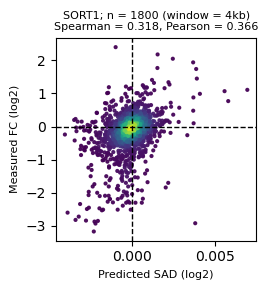

element = 'GP1BA'
 - n datapoints = 1154
 - n targets    = 866


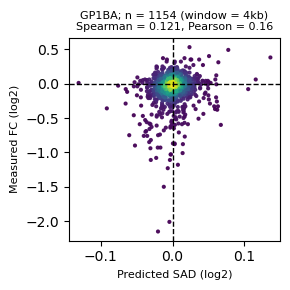

element = 'HBB'
 - n datapoints = 561
 - n targets    = 866


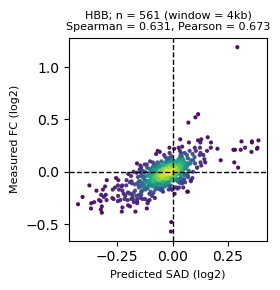

element = 'HBG1'
 - n datapoints = 822
 - n targets    = 866


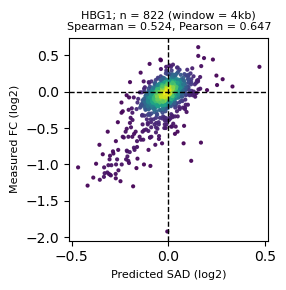

element = 'PKLR'
 - n datapoints = 1407
 - n targets    = 866


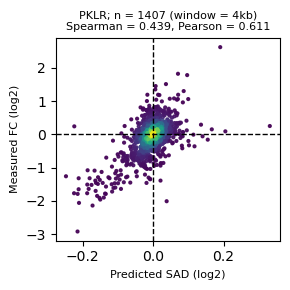

element = 'HNF4A'
 - n datapoints = 855
 - n targets    = 866


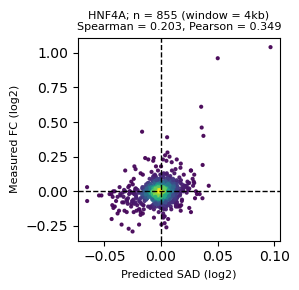

element = 'MSMB'
 - n datapoints = 1773
 - n targets    = 866


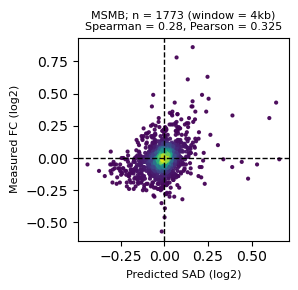

element = 'TERT'
 - n datapoints = 777
 - n targets    = 866


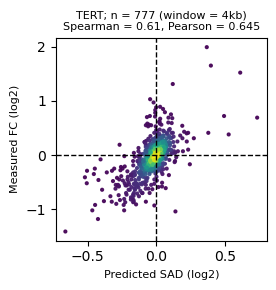

element = 'MYCrs6983267'
element = 'ZFAND3'
 - n datapoints = 1736
 - n targets    = 866


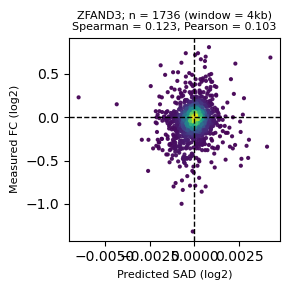

element = 'IRF6'
 - n datapoints = 1785
 - n targets    = 866


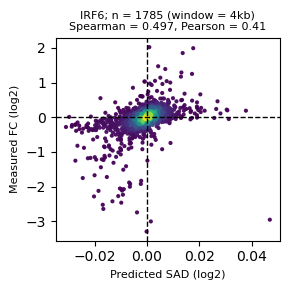

element = 'IRF4'
 - n datapoints = 1353
 - n targets    = 866


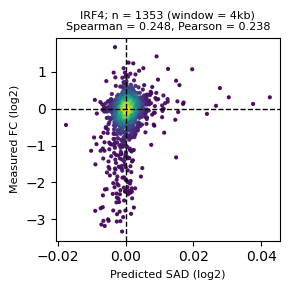

In [16]:
#Plot and record performances (pearson/spearman correlations)

print("--- Cell type-agnostic RNA ---")

target_mode = 'rna'
target_dict = rna_dict

pearson_rs_rna_agnostic, spearman_rs_rna_agnostic = _plot_and_record_perf(target_mode, target_dict, elements, max_p_val=1., n_sample_kde=500)


--- Cell type-specific RNA ---
element = 'F9'
 - n datapoints = 904
 - n targets    = 21


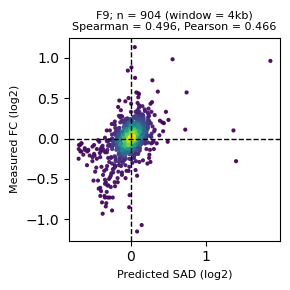

element = 'LDLR'
 - n datapoints = 954
 - n targets    = 18


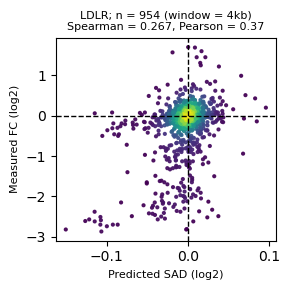

element = 'SORT1'
 - n datapoints = 1800
 - n targets    = 7


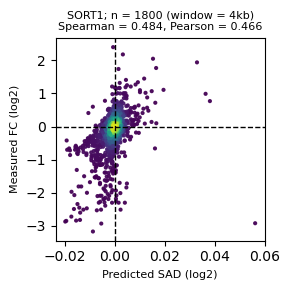

element = 'GP1BA'
 - n datapoints = 1154
 - n targets    = 21


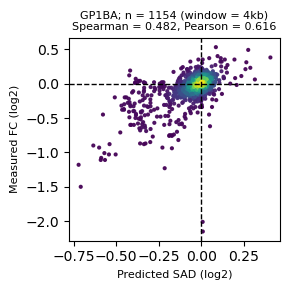

element = 'HBB'
 - n datapoints = 561
 - n targets    = 21


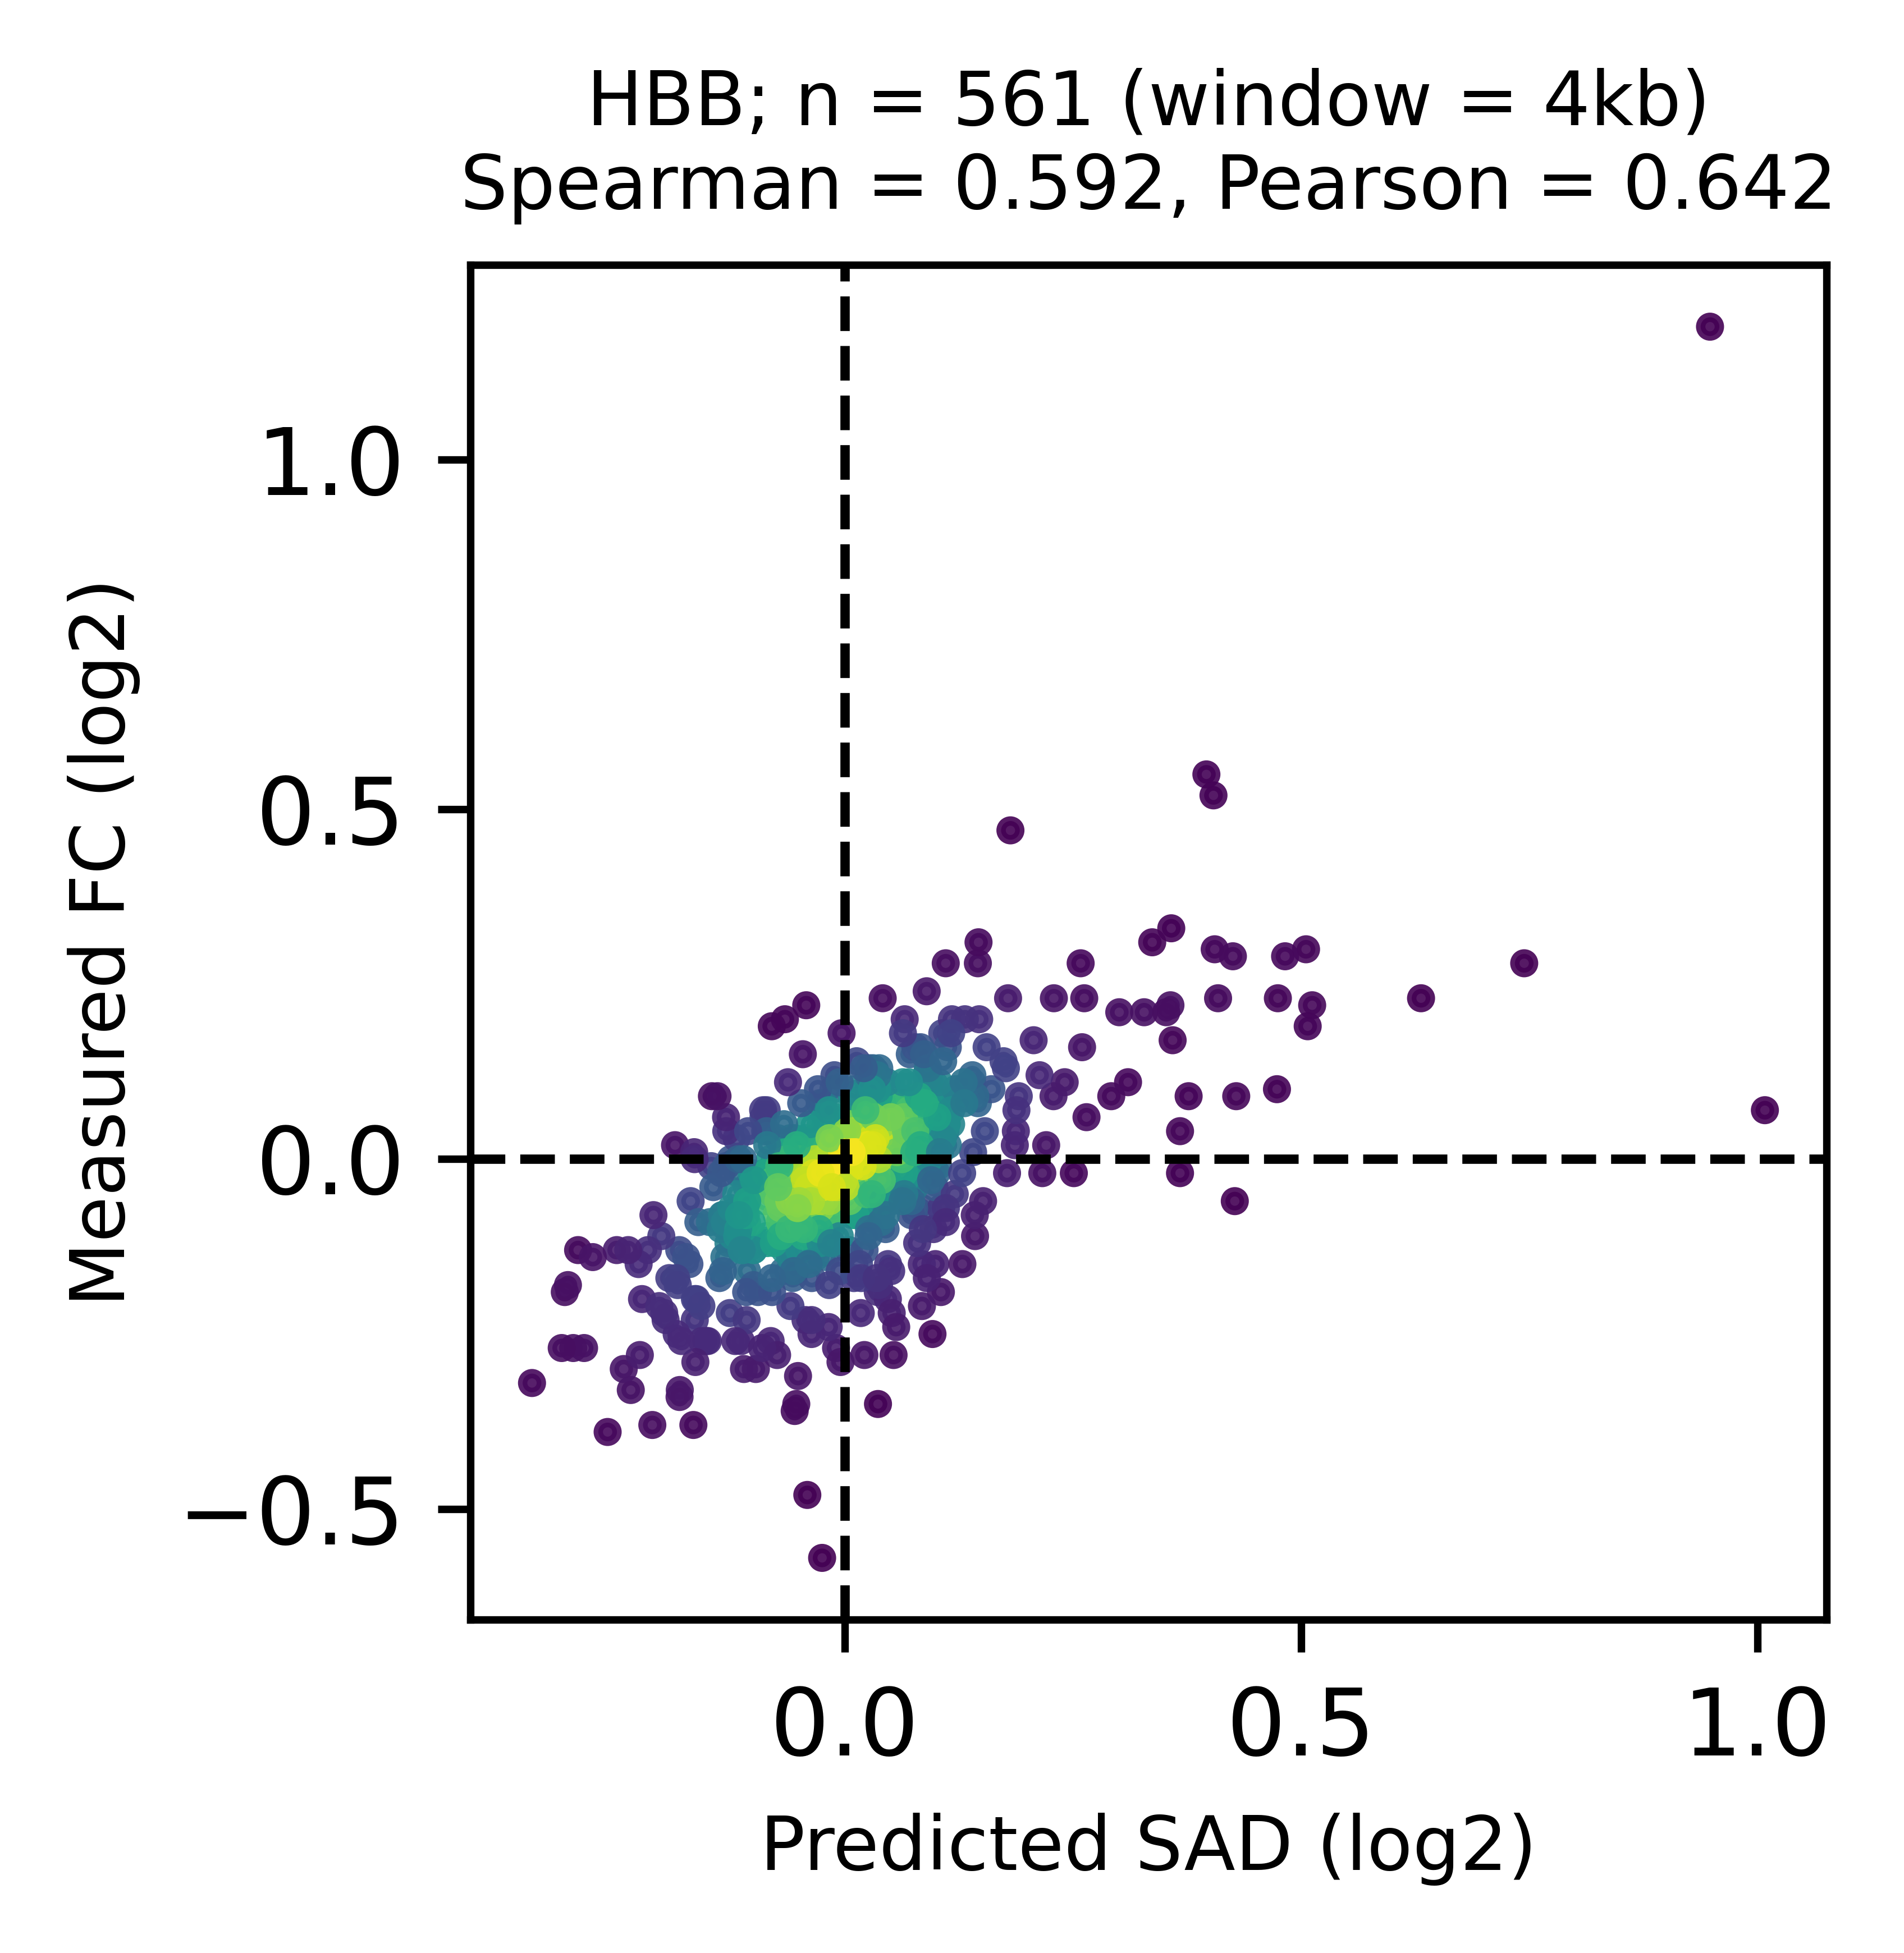

np.min(ism_hat) = -0.471
np.max(ism_hat) = 0.17
np.min(ism) = -0.292
np.max(ism) = 0.238


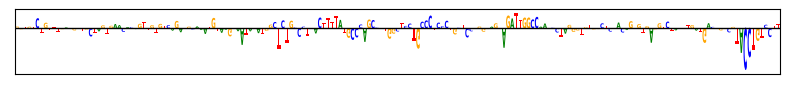

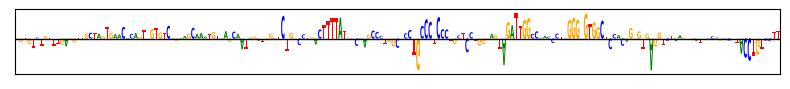

element = 'HBG1'
 - n datapoints = 822
 - n targets    = 21


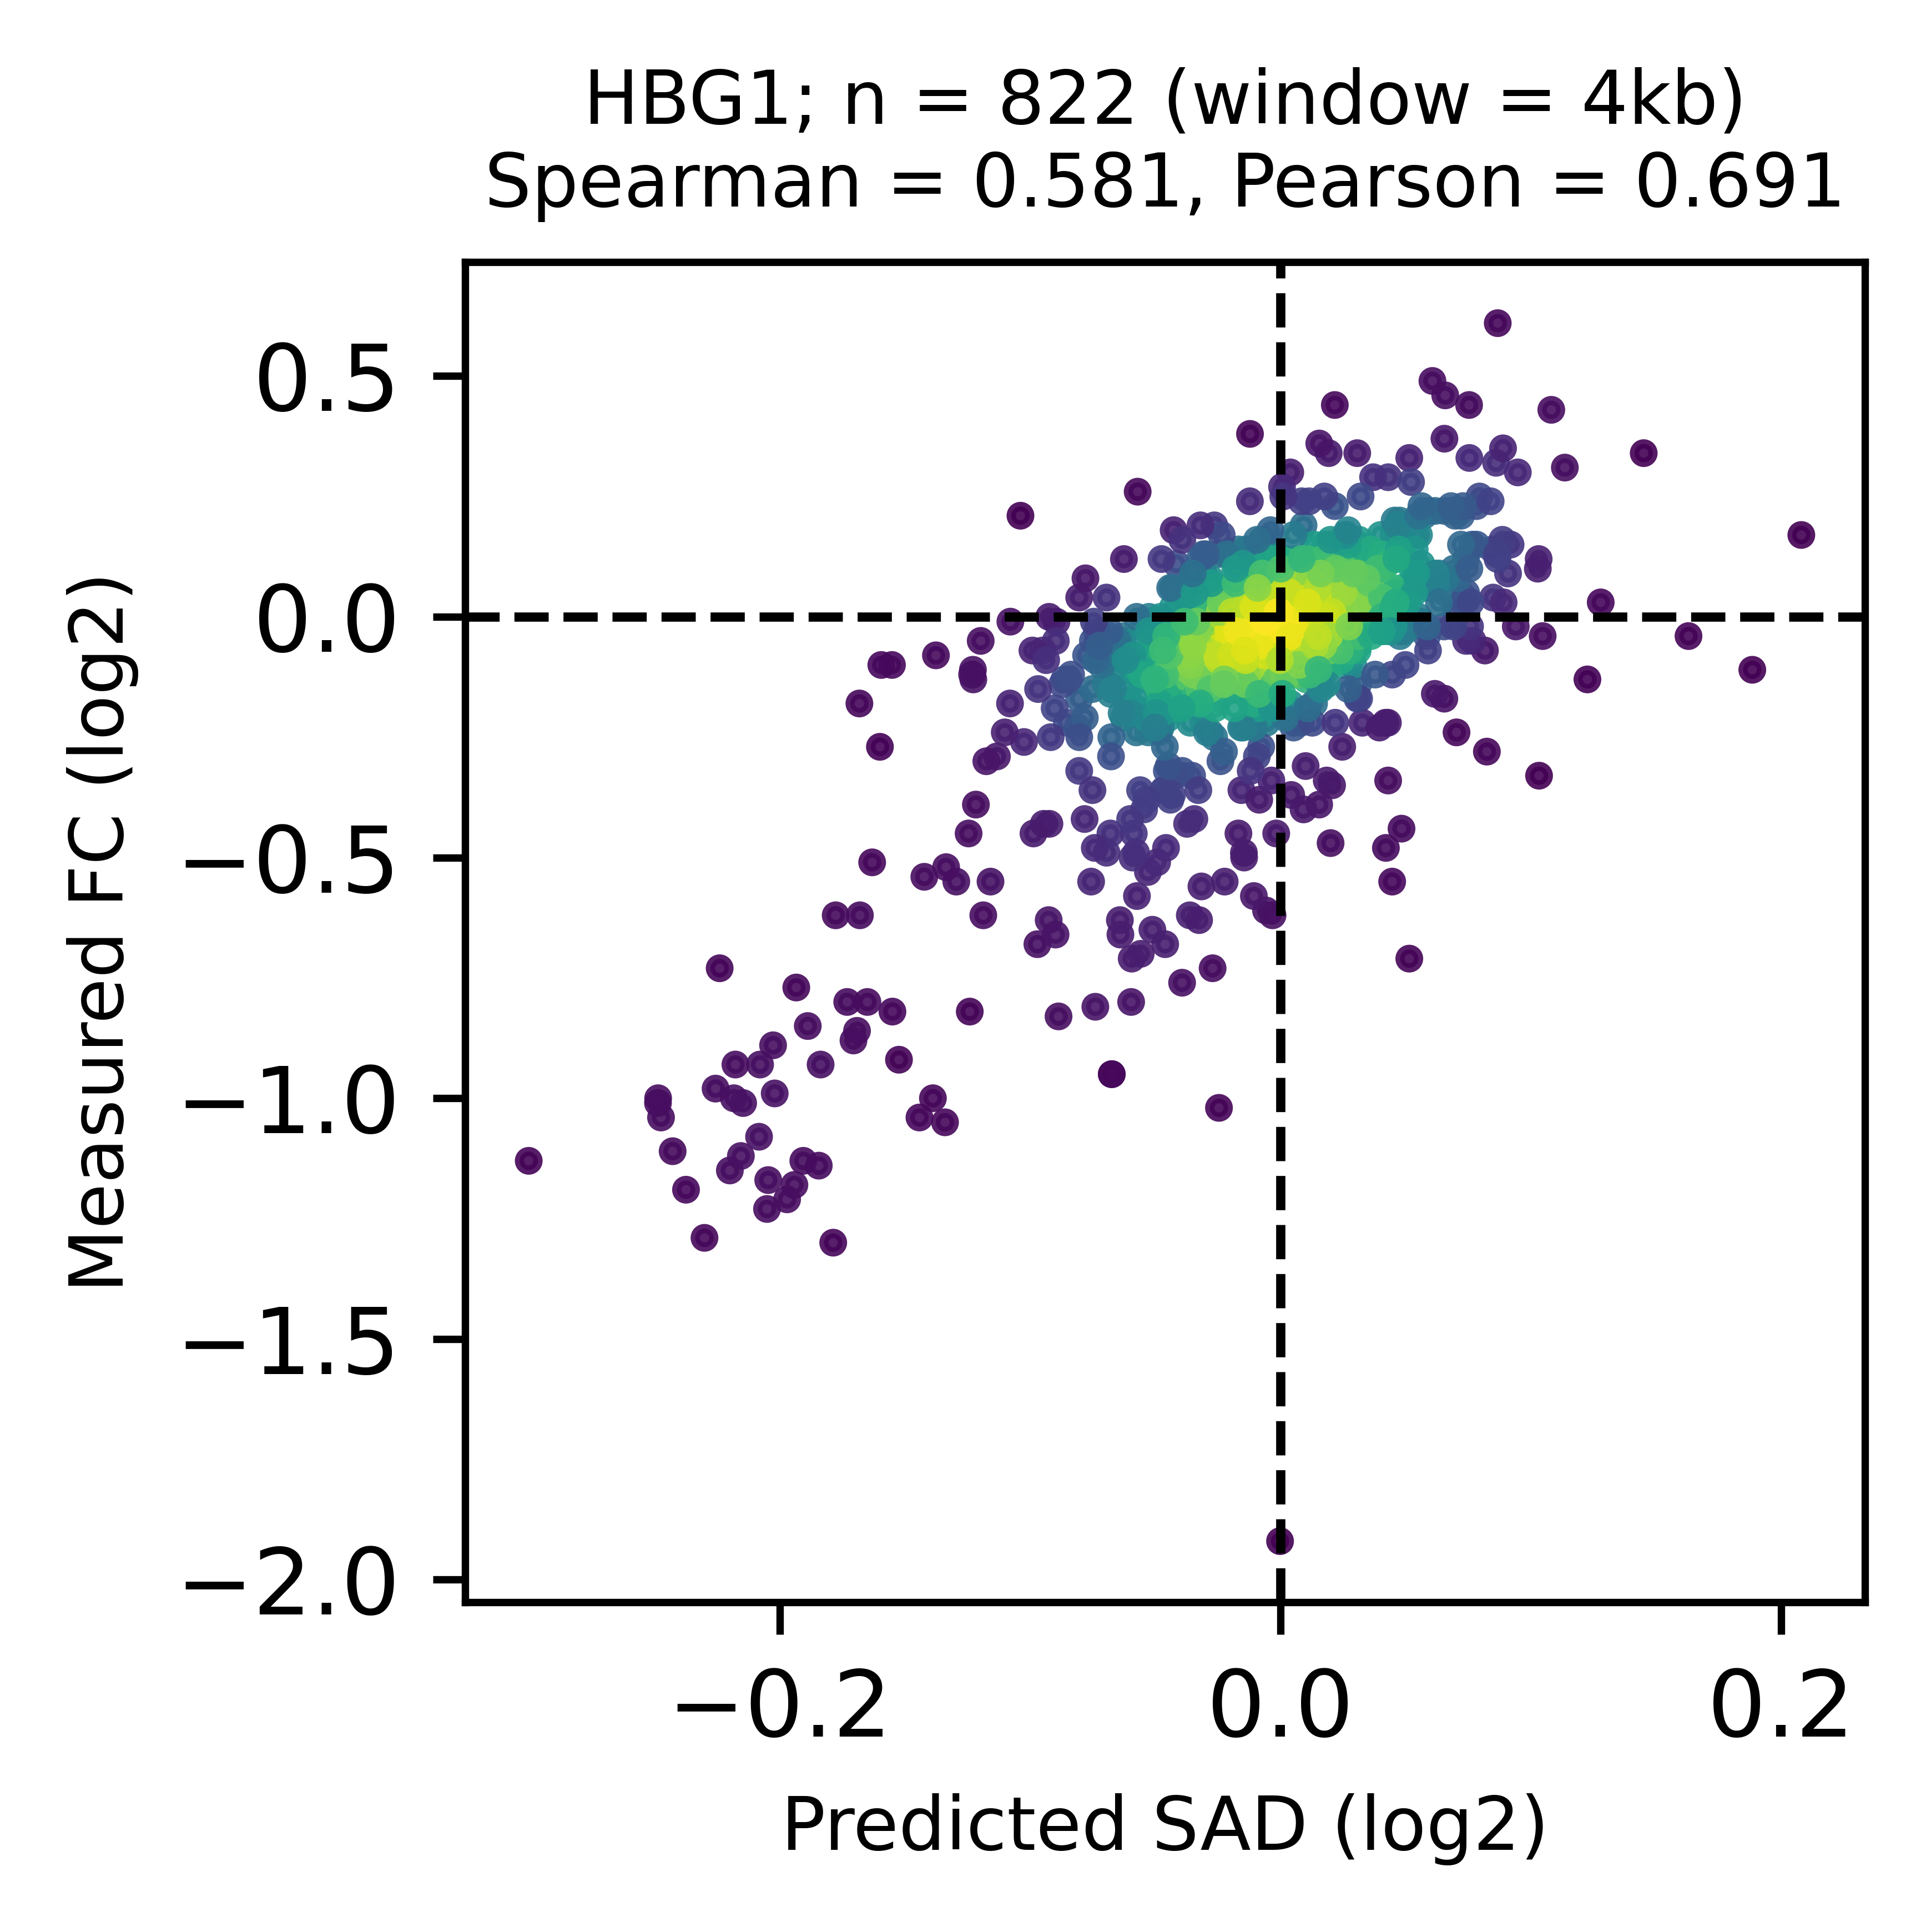

np.min(ism_hat) = -0.104
np.max(ism_hat) = 0.167
np.min(ism) = -0.238
np.max(ism) = 0.842


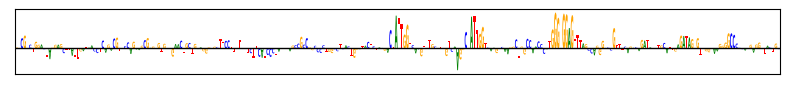

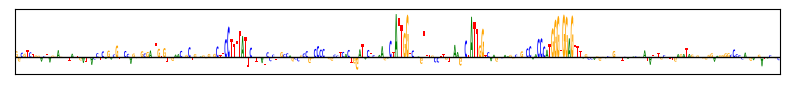

element = 'PKLR'
 - n datapoints = 1407
 - n targets    = 21


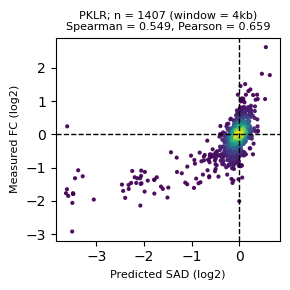

element = 'HNF4A'
 - n datapoints = 855
 - n targets    = 18


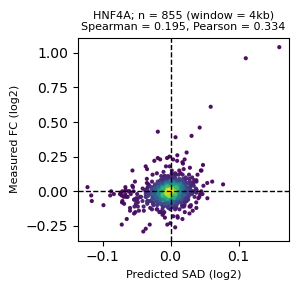

element = 'MSMB'
 - n datapoints = 1773
 - n targets    = 18


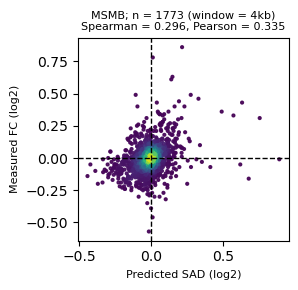

element = 'TERT'
 - n datapoints = 777
 - n targets    = 18


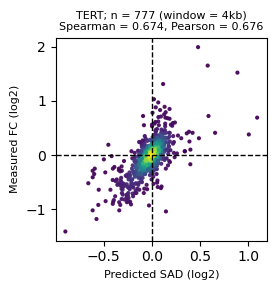

element = 'MYCrs6983267'
element = 'ZFAND3'
 - n datapoints = 1736
 - n targets    = 16


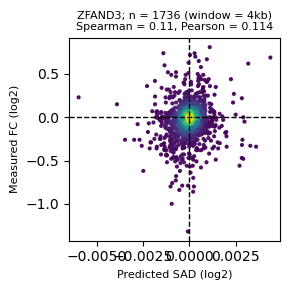

element = 'IRF6'
 - n datapoints = 1785
 - n targets    = 8


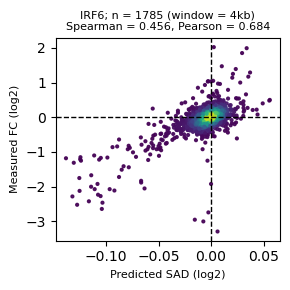

element = 'IRF4'
 - n datapoints = 1353
 - n targets    = 7


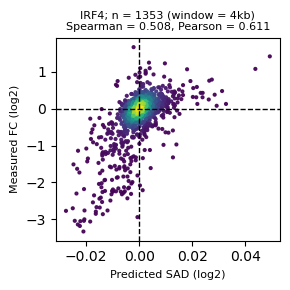

In [17]:
#Plot and record performances (pearson/spearman correlations)

print("--- Cell type-specific RNA ---")

target_mode = 'specific'
target_dict = rna_dict

pearson_rs_rna, spearman_rs_rna = _plot_and_record_perf(target_mode, target_dict, elements, max_p_val=1., n_sample_kde=500, save_figs=['HBB', 'HBG1'], fig_name='satmut_borzoi_sed_4k_opt', plot_isms=['HBB', 'HBG1'])


--- Cell type-agnostic DNase + H3K + RNA ---
element = 'F9'
 - n datapoints = 904
 - n targets    = 2554


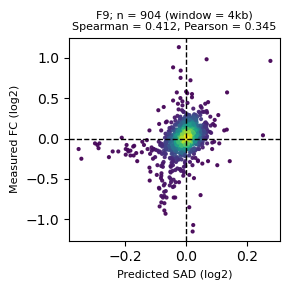

element = 'LDLR'
 - n datapoints = 954
 - n targets    = 2554


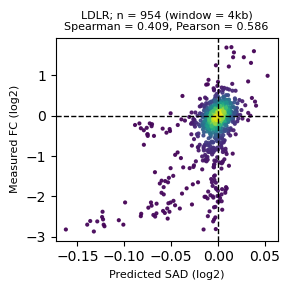

element = 'SORT1'
 - n datapoints = 1800
 - n targets    = 2554


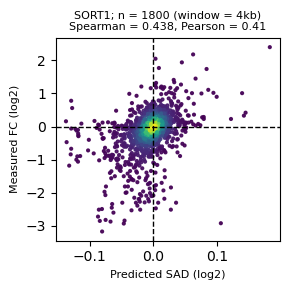

element = 'GP1BA'
 - n datapoints = 1154
 - n targets    = 2554


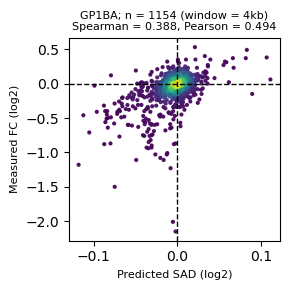

element = 'HBB'
 - n datapoints = 561
 - n targets    = 2554


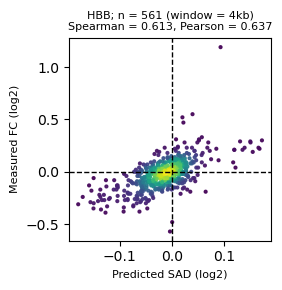

element = 'HBG1'
 - n datapoints = 822
 - n targets    = 2554


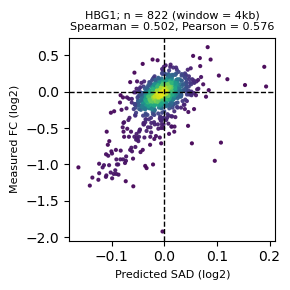

element = 'PKLR'
 - n datapoints = 1407
 - n targets    = 2554


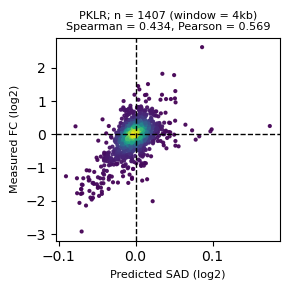

element = 'HNF4A'
 - n datapoints = 855
 - n targets    = 2554


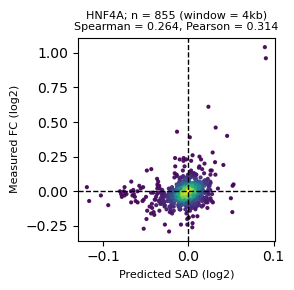

element = 'MSMB'
 - n datapoints = 1773
 - n targets    = 2554


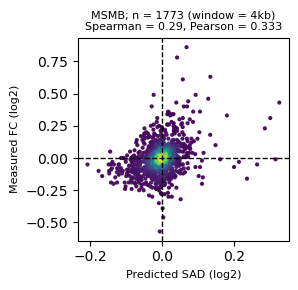

element = 'TERT'
 - n datapoints = 777
 - n targets    = 2554


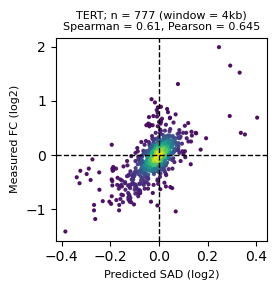

element = 'MYCrs6983267'
 - n datapoints = 1792
 - n targets    = 1599


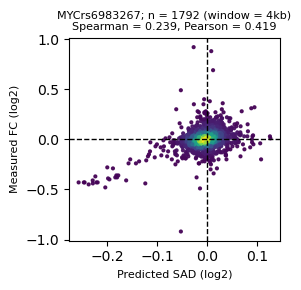

element = 'ZFAND3'
 - n datapoints = 1736
 - n targets    = 2554


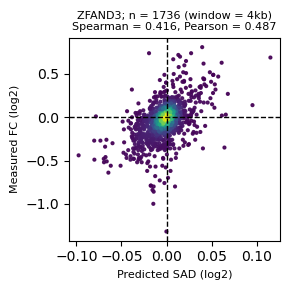

element = 'IRF6'
 - n datapoints = 1785
 - n targets    = 2554


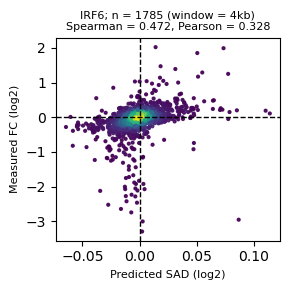

element = 'IRF4'
 - n datapoints = 1353
 - n targets    = 2554


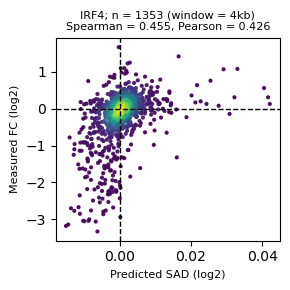

In [18]:
#Plot and record performances (pearson/spearman correlations)

print("--- Cell type-agnostic DNase + H3K + RNA ---")

target_mode = 'dnase_and_h3k_and_rna'
target_dict = dnase_and_h3k_and_rna_dict

pearson_rs_dnase_and_h3k_and_rna_agnostic, spearman_rs_dnase_and_h3k_and_rna_agnostic = _plot_and_record_perf(target_mode, target_dict, elements, max_p_val=1., n_sample_kde=500)


--- Cell type-specific DNase + H3K + RNA ---
element = 'F9'
 - n datapoints = 904
 - n targets    = 29


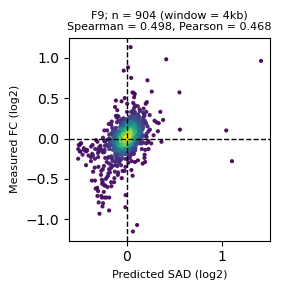

element = 'LDLR'
 - n datapoints = 954
 - n targets    = 35


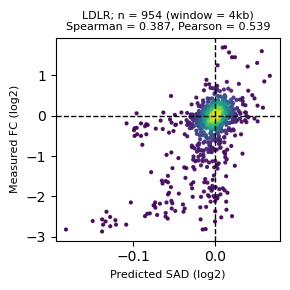

element = 'SORT1'
 - n datapoints = 1800
 - n targets    = 12


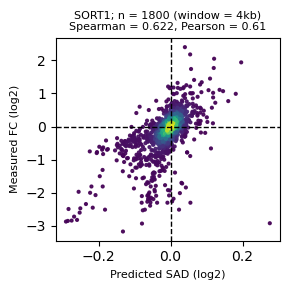

element = 'GP1BA'
 - n datapoints = 1154
 - n targets    = 29


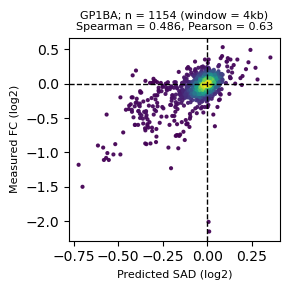

element = 'HBB'
 - n datapoints = 561
 - n targets    = 29


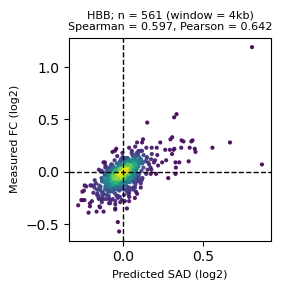

element = 'HBG1'
 - n datapoints = 822
 - n targets    = 29


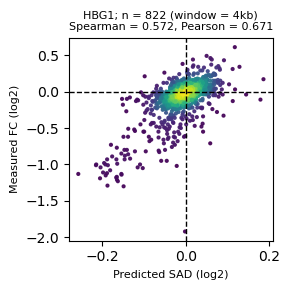

element = 'PKLR'
 - n datapoints = 1407
 - n targets    = 29


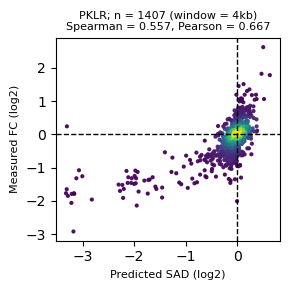

element = 'HNF4A'
 - n datapoints = 855
 - n targets    = 20


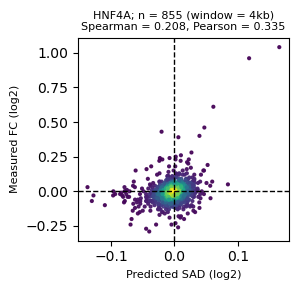

element = 'MSMB'
 - n datapoints = 1773
 - n targets    = 20


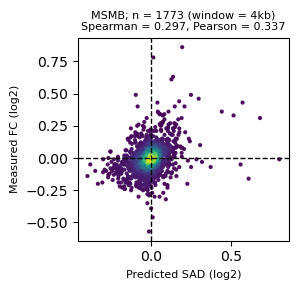

element = 'TERT'
 - n datapoints = 777
 - n targets    = 20


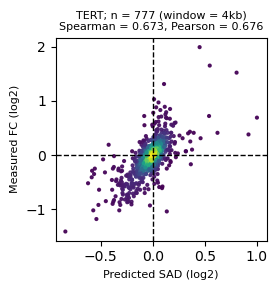

element = 'MYCrs6983267'
 - n datapoints = 1792
 - n targets    = 2


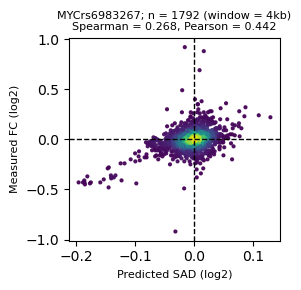

element = 'ZFAND3'
 - n datapoints = 1736
 - n targets    = 36


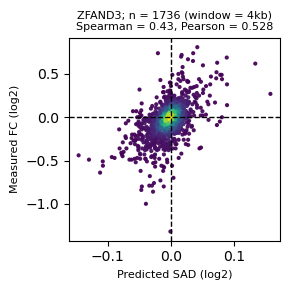

element = 'IRF6'
 - n datapoints = 1785
 - n targets    = 17


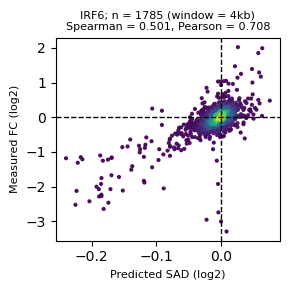

element = 'IRF4'
 - n datapoints = 1353
 - n targets    = 14


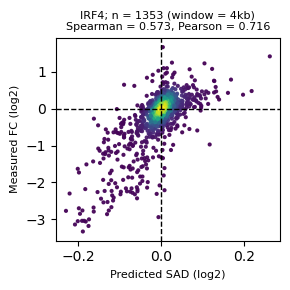

In [19]:
#Plot and record performances (pearson/spearman correlations)

print("--- Cell type-specific DNase + H3K + RNA ---")

target_mode = 'specific'
target_dict = dnase_and_h3k_and_rna_dict

pearson_rs_dnase_and_h3k_and_rna, spearman_rs_dnase_and_h3k_and_rna = _plot_and_record_perf(target_mode, target_dict, elements, max_p_val=1., n_sample_kde=500)


In [20]:
#Compile final performance matrices

#Pearson matrix
pearson_mat = np.concatenate([
    pearson_rs_dnase_agnostic[None, :],
    pearson_rs_dnase[None, :],
    pearson_rs_dnase_and_h3k_agnostic[None, :],
    pearson_rs_dnase_and_h3k[None, :],
    pearson_rs_rna_agnostic[None, :],
    pearson_rs_rna[None, :],
    pearson_rs_dnase_and_h3k_and_rna_agnostic[None, :],
    pearson_rs_dnase_and_h3k_and_rna[None, :],
], axis=0)

#Spearman matrix
spearman_mat = np.concatenate([
    spearman_rs_dnase_agnostic[None, :],
    spearman_rs_dnase[None, :],
    spearman_rs_dnase_and_h3k_agnostic[None, :],
    spearman_rs_dnase_and_h3k[None, :],
    spearman_rs_rna_agnostic[None, :],
    spearman_rs_rna[None, :],
    spearman_rs_dnase_and_h3k_and_rna_agnostic[None, :],
    spearman_rs_dnase_and_h3k_and_rna[None, :],
], axis=0)

#Cache performance metrics
np.save('satmut_borzoi_4k_pearson_opt', pearson_mat)
np.save('satmut_borzoi_4k_spearman_opt', spearman_mat)


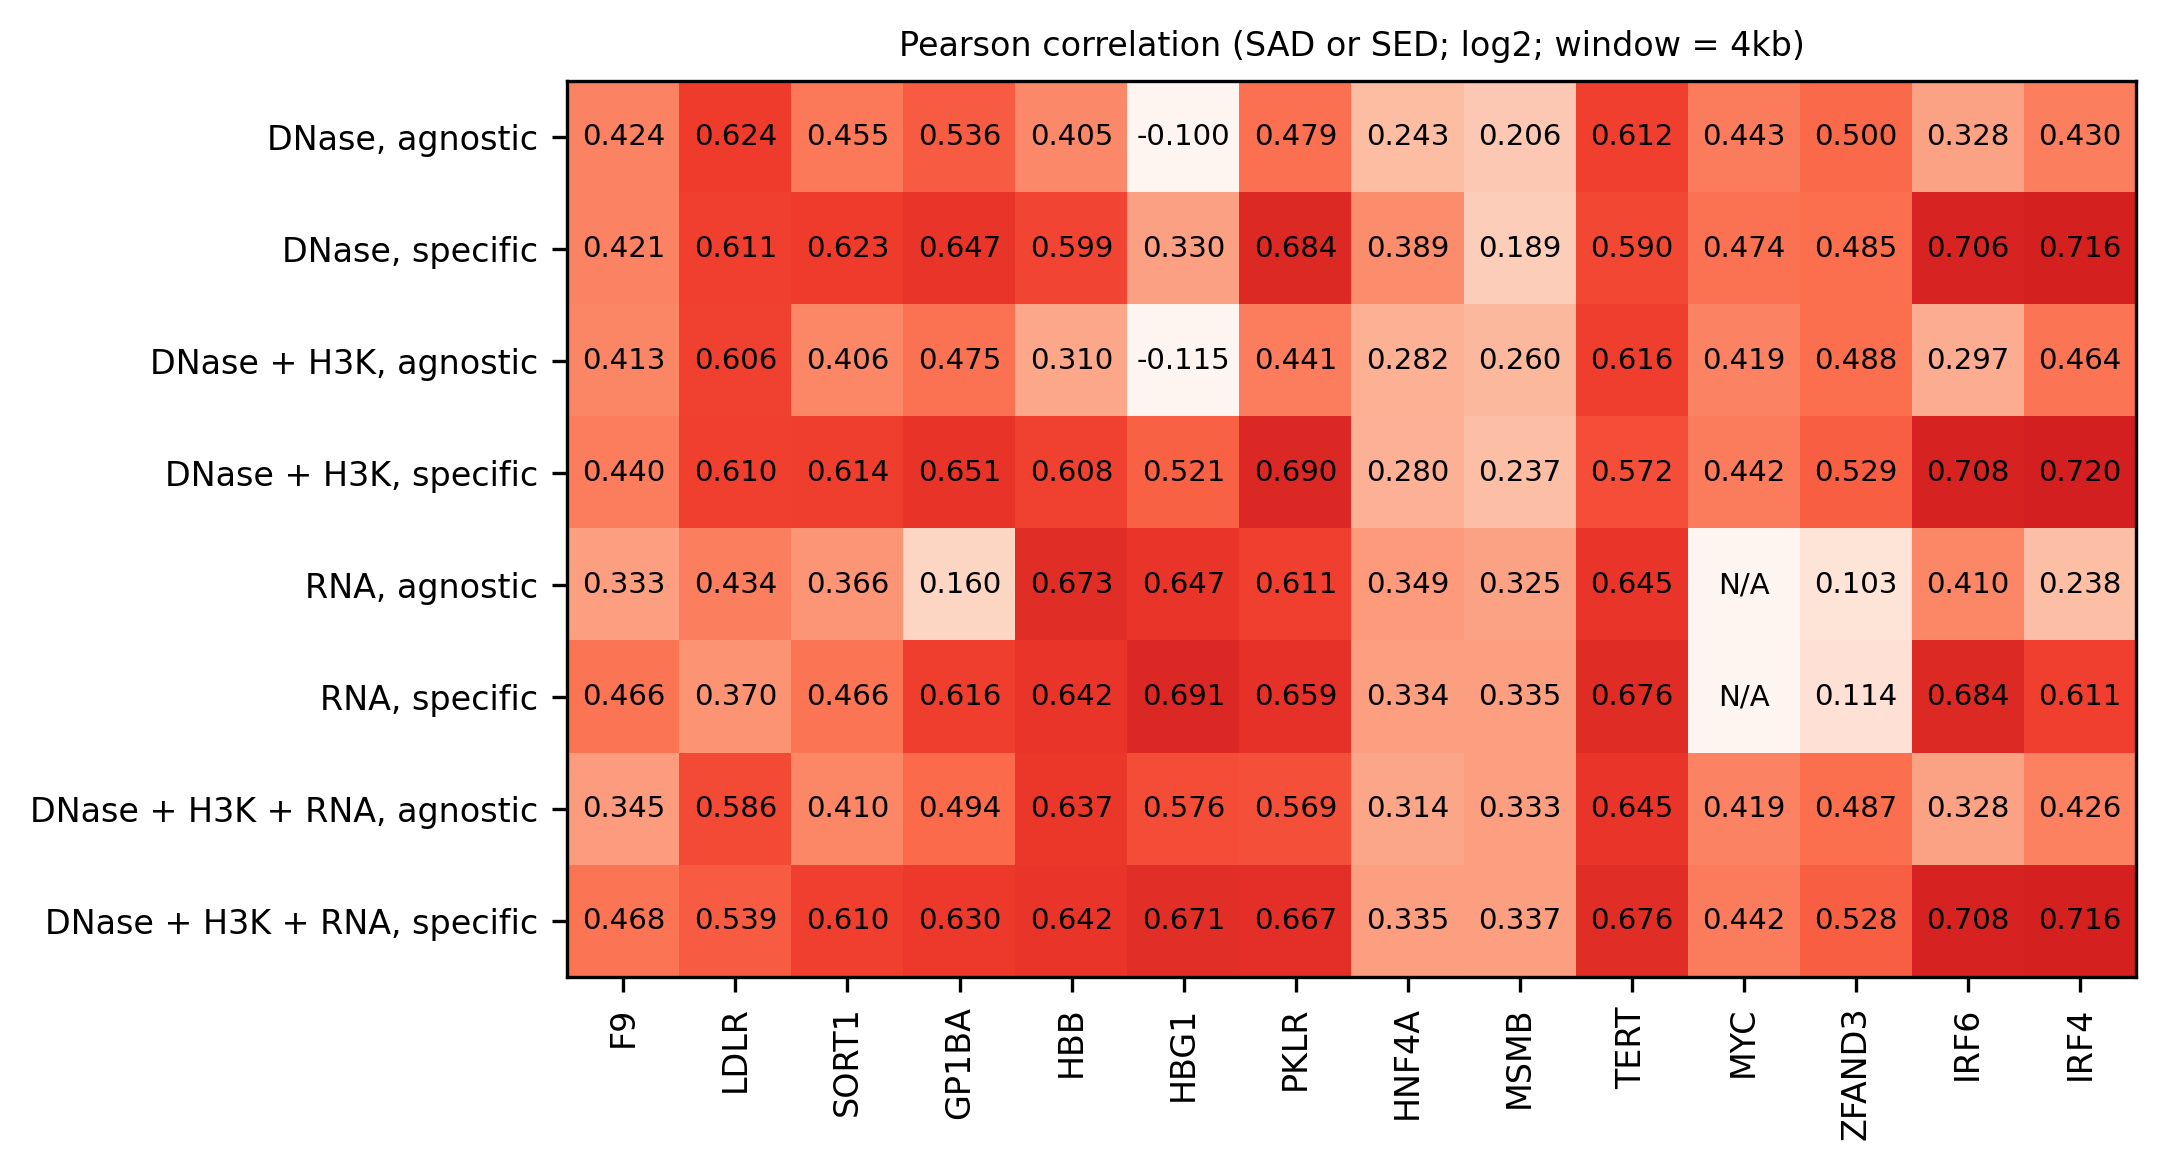

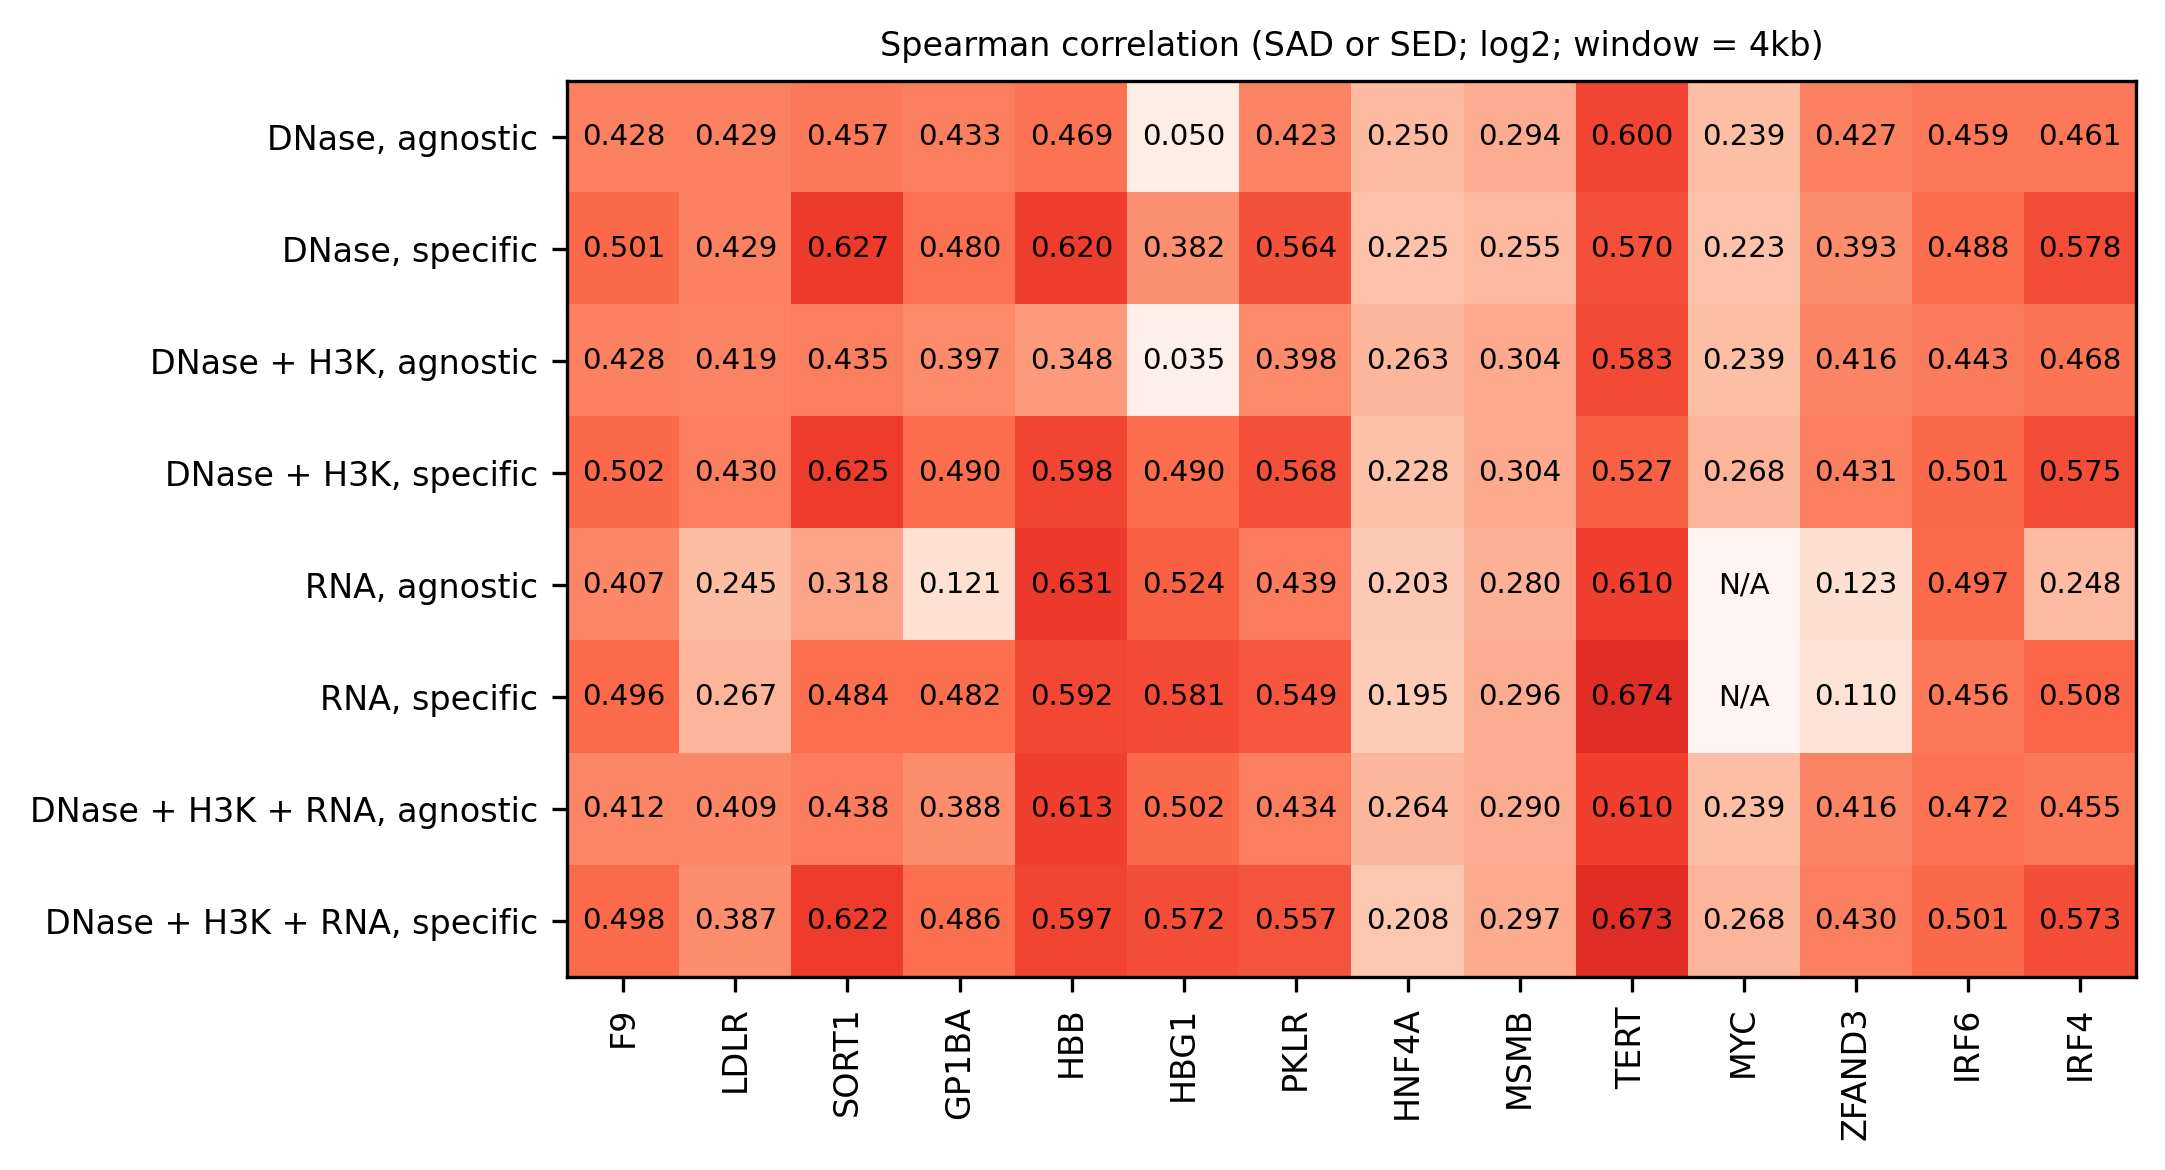

In [21]:
#Plot heatmap with summary performance

data_strs = [
    'DNase, agnostic',
    'DNase, specific',
    'DNase + H3K, agnostic',
    'DNase + H3K, specific',
    'RNA, agnostic',
    'RNA, specific',
    'DNase + H3K + RNA, agnostic',
    'DNase + H3K + RNA, specific',
]

elements = [
    "F9",
    "LDLR",
    "SORT1",
    "GP1BA",
    "HBB",
    "HBG1",
    "PKLR",
    "HNF4A",
    "MSMB",
    "TERT",
    "MYC",
    "ZFAND3",
    "IRF6",
    "IRF4",
]

#Plot pearson correlations
f = plt.figure(figsize=(10, 4), dpi=300)

plt.imshow(pearson_mat, cmap='Reds', vmin=0., vmax=1.)

for y in range(pearson_mat.shape[0]):
    for x in range(pearson_mat.shape[1]):
        plt.text(
            x,
            y,
            '%.3f' % pearson_mat[y, x] if pearson_mat[y, x] != 0. else 'N/A',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=7
        )

plt.xticks(np.arange(pearson_mat.shape[1]), elements, fontsize=8, rotation=90)
plt.yticks(np.arange(pearson_mat.shape[0]), data_strs, fontsize=8)

plt.title("Pearson correlation (SAD or SED; log2; window = 4kb)", fontsize=8)

plt.tight_layout()

plt.show()

#Plot spearman correlations
f = plt.figure(figsize=(10, 4), dpi=300)

plt.imshow(spearman_mat, cmap='Reds', vmin=0., vmax=1.)

for y in range(spearman_mat.shape[0]):
    for x in range(spearman_mat.shape[1]):
        plt.text(
            x,
            y,
            '%.3f' % spearman_mat[y, x] if spearman_mat[y, x] != 0. else 'N/A',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=7
        )

plt.xticks(np.arange(spearman_mat.shape[1]), elements, fontsize=8, rotation=90)
plt.yticks(np.arange(spearman_mat.shape[0]), data_strs, fontsize=8)

plt.title("Spearman correlation (SAD or SED; log2; window = 4kb)", fontsize=8)

plt.tight_layout()

plt.show()


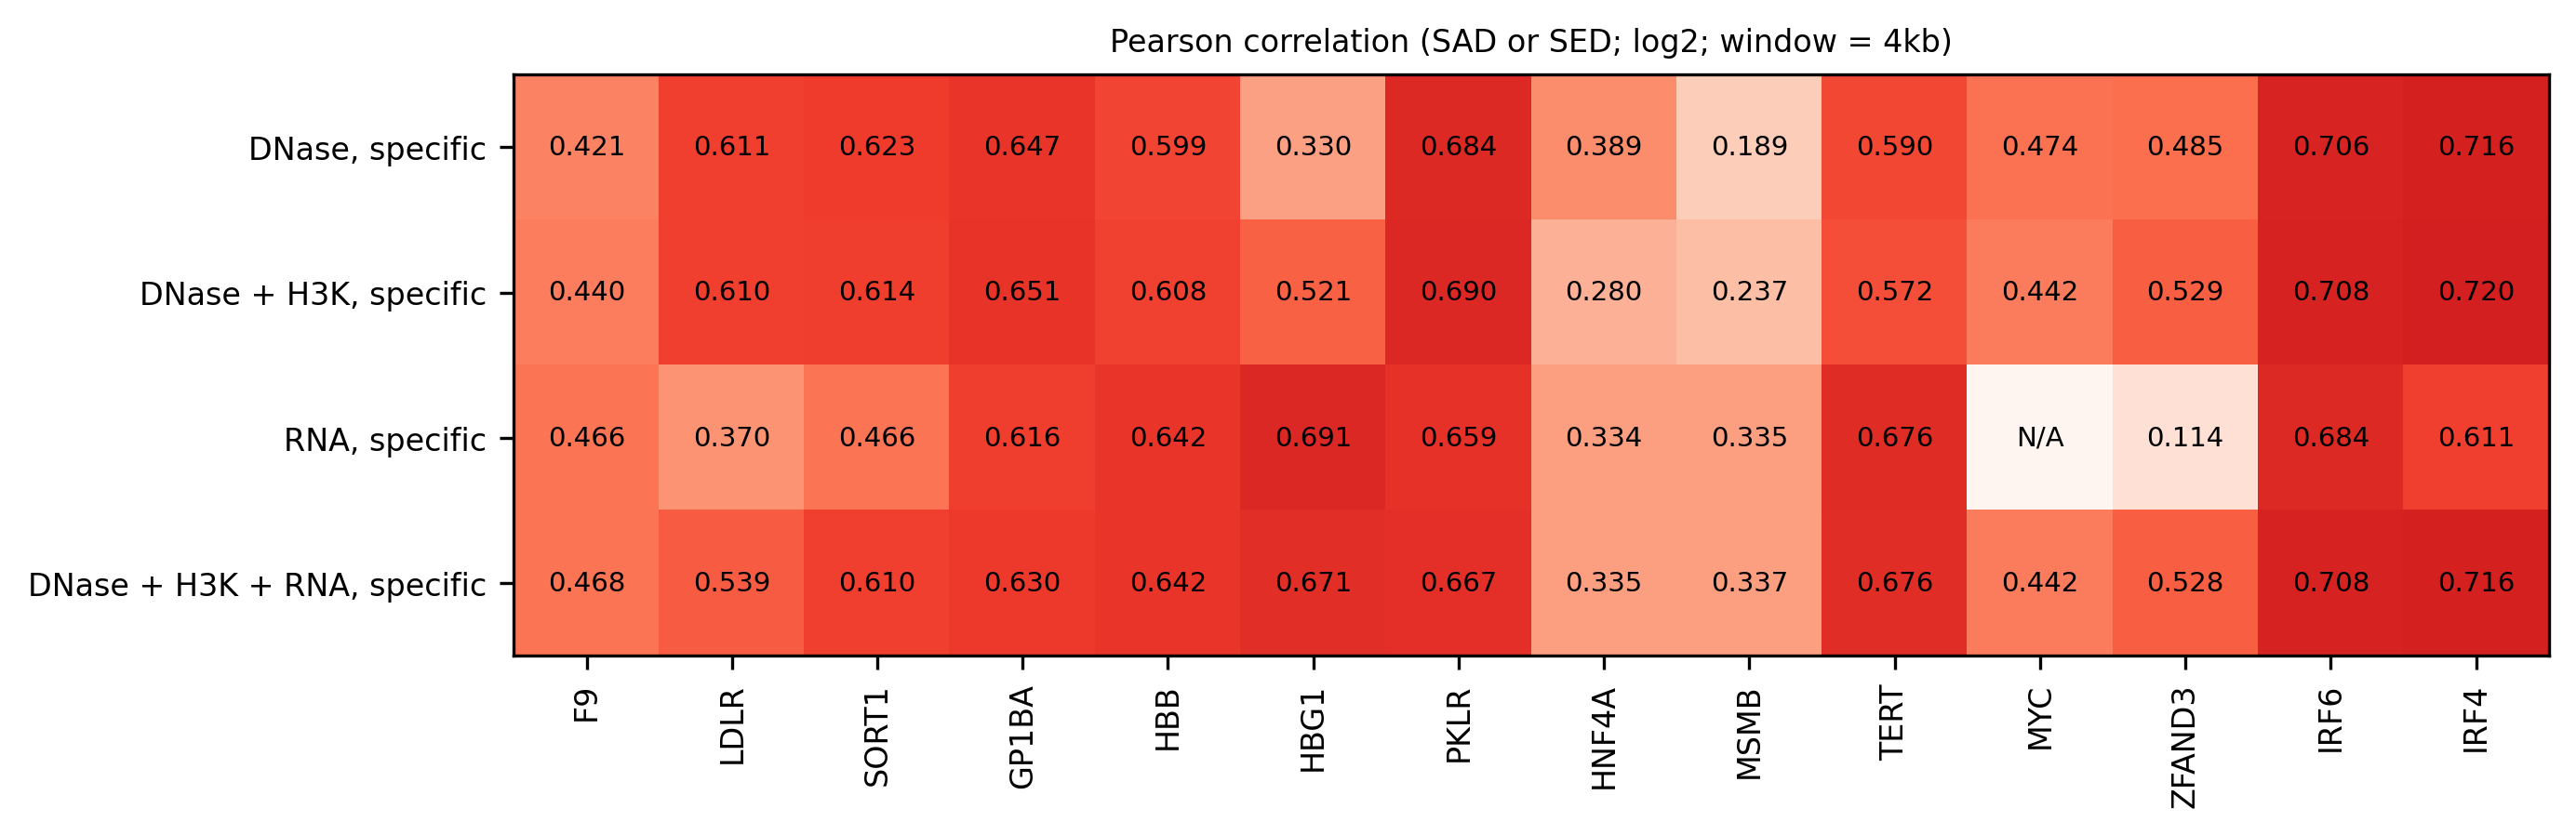

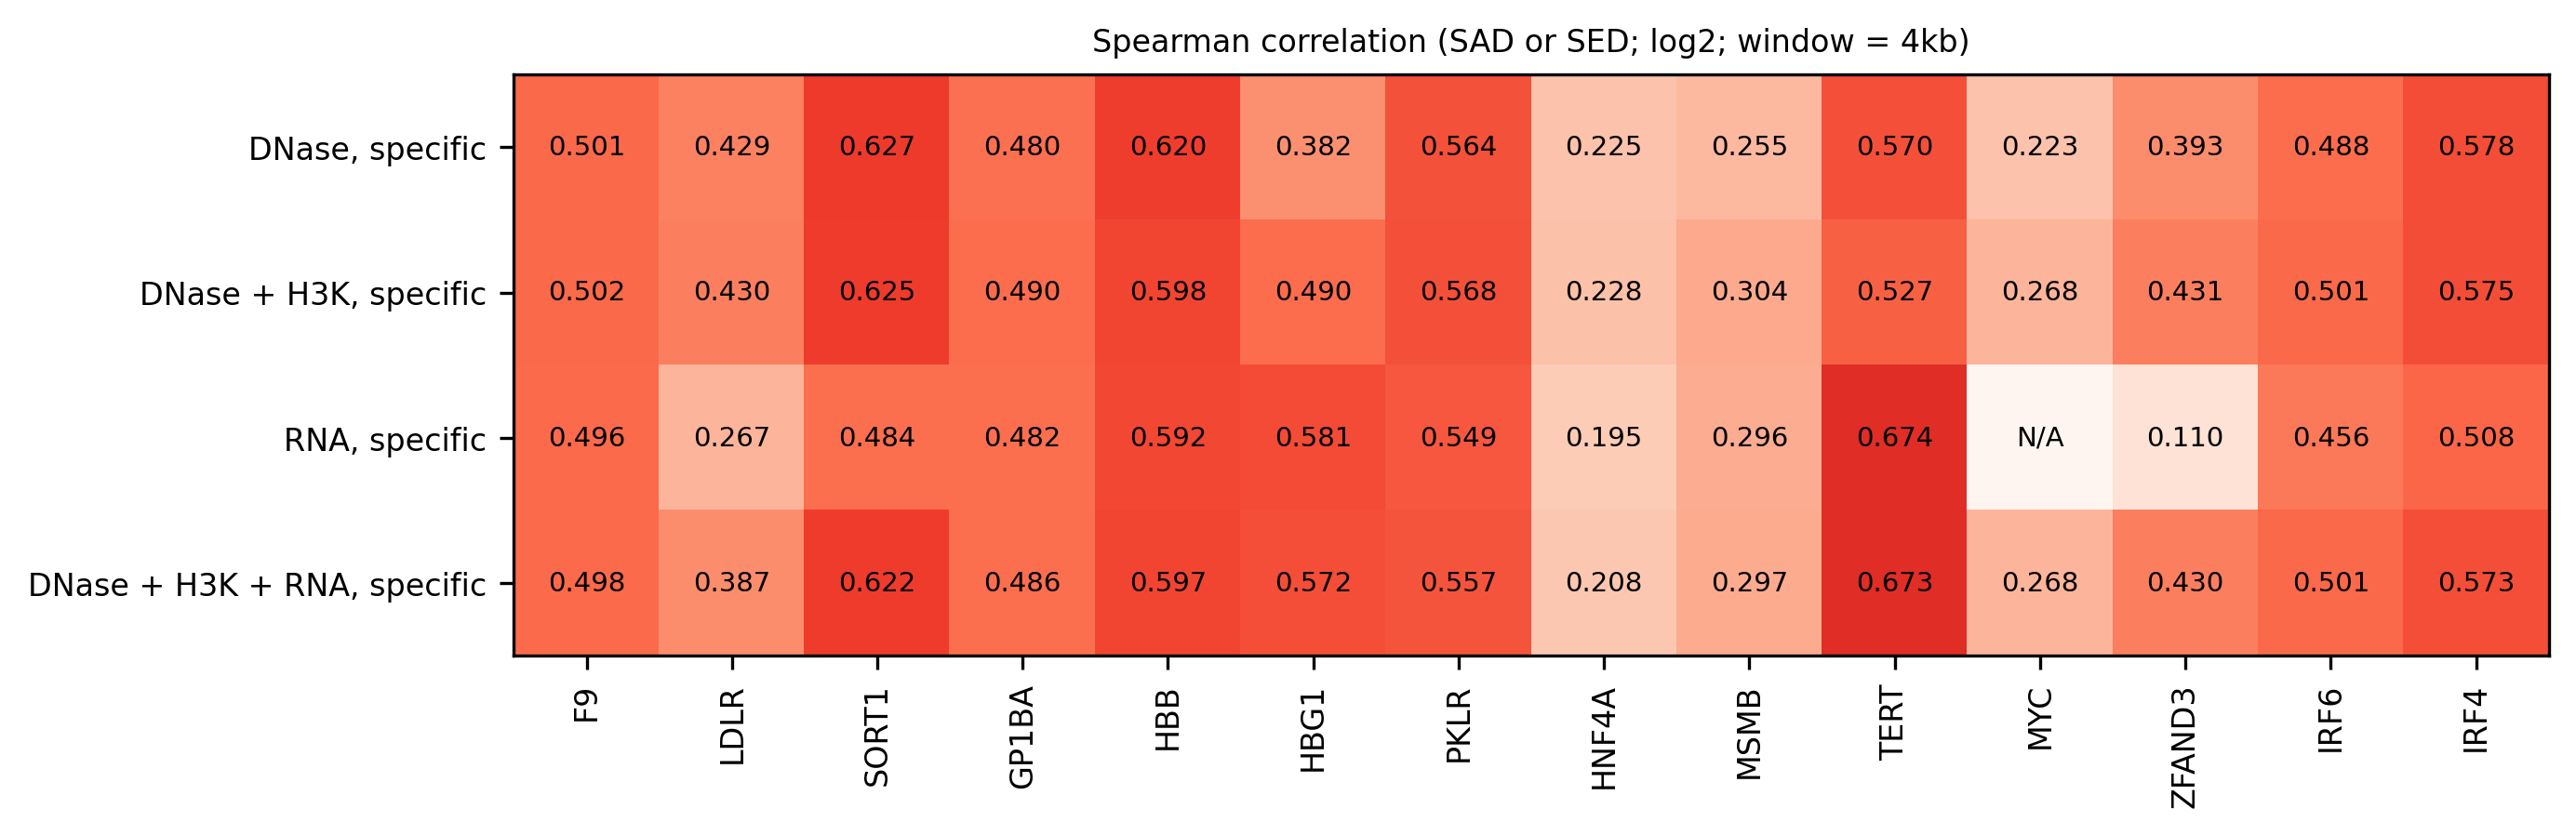

In [22]:
#Plot heatmap with summary performance (cell type-specific only)

data_strs = [
    'DNase, specific',
    'DNase + H3K, specific',
    'RNA, specific',
    'DNase + H3K + RNA, specific',
]

elements = [
    "F9",
    "LDLR",
    "SORT1",
    "GP1BA",
    "HBB",
    "HBG1",
    "PKLR",
    "HNF4A",
    "MSMB",
    "TERT",
    "MYC",
    "ZFAND3",
    "IRF6",
    "IRF4",
]

#Pearson matrix
pearson_mat_specific = pearson_mat[[1, 3, 5, 7], :]

#Spearman matrix
spearman_mat_specific = spearman_mat[[1, 3, 5, 7], :]

#Plot pearson correlations
f = plt.figure(figsize=(10, 3), dpi=300)

plt.imshow(pearson_mat_specific, cmap='Reds', vmin=0., vmax=1.)

for y in range(pearson_mat_specific.shape[0]):
    for x in range(pearson_mat_specific.shape[1]):
        plt.text(
            x,
            y,
            '%.3f' % pearson_mat_specific[y, x] if pearson_mat_specific[y, x] != 0. else 'N/A',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=7
        )

plt.xticks(np.arange(pearson_mat_specific.shape[1]), elements, fontsize=8, rotation=90)
plt.yticks(np.arange(pearson_mat_specific.shape[0]), data_strs, fontsize=8)

plt.title("Pearson correlation (SAD or SED; log2; window = 4kb)", fontsize=8)

plt.tight_layout()

plt.show()

#Plot spearman correlations
f = plt.figure(figsize=(10, 3), dpi=300)

plt.imshow(spearman_mat_specific, cmap='Reds', vmin=0., vmax=1.)

for y in range(spearman_mat_specific.shape[0]):
    for x in range(spearman_mat_specific.shape[1]):
        plt.text(
            x,
            y,
            '%.3f' % spearman_mat_specific[y, x] if spearman_mat_specific[y, x] != 0. else 'N/A',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=7
        )

plt.xticks(np.arange(spearman_mat_specific.shape[1]), elements, fontsize=8, rotation=90)
plt.yticks(np.arange(spearman_mat_specific.shape[0]), data_strs, fontsize=8)

plt.title("Spearman correlation (SAD or SED; log2; window = 4kb)", fontsize=8)

plt.tight_layout()

plt.show()
